In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
from itertools import combinations
from scipy import stats
import seaborn as sns

from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [3]:
filepath = "filtered_data/adjacent1MBfiltered.csv"

adjDf = pd.read_csv(filepath)
adjDf['filterType'] = 'adjacent'

print(f"{adjDf.shape=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


adjDf.shape=(286943, 66)


In [4]:
filepath = "filtered_data/clique1MBfiltered.csv"

cliqDf = pd.read_csv(filepath)
cliqDf['filterType'] = 'expanded'

print(f"{cliqDf.shape=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


cliqDf.shape=(636130, 66)


In [5]:
# combine the datasets

df = pd.concat([adjDf, cliqDf], ignore_index=True)
print(f"{df.shape=}")
df['filterType'].value_counts()

df.shape=(923073, 66)


expanded    636130
adjacent    286943
Name: filterType, dtype: int64

In [6]:
resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

adj1mb = {}
exp1mb = {}

for cell in df['cell'].unique():
    
    cellAdj = df[(df['cell'] == cell) & (df['filterType'] == 'adjacent')].reset_index(drop=True)
    cellExp = df[(df['cell'] == cell) & (df['filterType'] == 'expanded')].reset_index(drop=True)
    
    cellAdjBinned = binning.wholeGenomeBinData(cellAdj, bins, label1, label2)
    cellExpBinned = binning.wholeGenomeBinData(cellExp, bins, label1, label2)
    
    Aadj = pcu.getHic(cellAdjBinned, bins, label1, label2)
    Aexp = pcu.getHic(cellExpBinned, bins, label1, label2)
    
    print(f"{cell=} {Aadj.shape=} {Aexp.shape=}")
    
    adj1mb[cell] = Aadj
    exp1mb[cell] = Aexp
    
print('done.')

cell='run01' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run02' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run04' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run05' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run06' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run07' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
done.


In [7]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)

filteredPoreCIndex = list(range(0, len(adj1mb['run01'])))

In [8]:
chromosome = ['chr2']

chrom2 = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    A = np.where(A > 0, 1, 0)
    np.fill_diagonal(A, 1)
    return A
    

for runId in adj1mb.keys():
    
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

    Aadj = processMat(adj1mb[runId], ind)
    Aexp = processMat(exp1mb[runId], ind)
    
    chrom2[runId] = {
        'adjacent' : Aadj,
        'expanded' : Aexp
    }
    
    
print('done.')

done.


# scHi-C Data

In [9]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))
print(f"{len(cellList)=}")

sampleSize = 500
chromosome = ['chr2']
sample = np.random.choice(cellList, sampleSize, replace=False)

hic = {}

for i, s in enumerate(sample):
    filetag = "_".join(s.split("_")[0:2]).replace("/", "") + f"_{i}"
    rawMat, hicChromInfo, hicIndex = pcu.loadNagano2017SingleCell(scHICfilepath, s, chromOrder, balance=False)
    
    hicChromInfo = hicChromInfo[hicChromInfo['region'].str.contains('random') == False]
    
    # re-order  the matrix
    hicMat = rawMat[hicIndex, :][:, hicIndex]
    
    # extract the second chromosome
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')

    A = hicMat[chrHicInd, :][:, chrHicInd]
   
    # binarize 
    A = np.where(A > 0, 1, 0)
    hic[filetag] = A
#     print(f"{filetag=} {A.shape=}")
    
print('done.')
print(f"{len(hic.keys())=}")

len(cellList)=3882
done.
len(hic.keys())=500


pX.mean()=0.05741408042506944
pX.max()=0.944
pX.min()=0.0

pXNorm.mean()=0.29632243915091067
pXNorm.max()=1.0
pXNorm.min()=0.18257268330994564


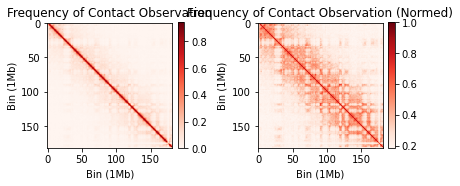

In [10]:
# generate a "probability" map 

d = 0.8

pX = np.zeros((182, 182))

for k, v in hic.items():
    pX += v
    
    
pX = pX / len(hic)
# pX = pcu.pageRankNorm(pX, d=d)


pXNorm = np.zeros(pX.shape)


# scale by distance
for i in range(len(pX)):
    for j in range(len(pX)):
        pXNorm[i, j] = pX[i, j] * np.log(np.abs(i -j) + d )
    

    
pXNorm = (pXNorm - np.min(pXNorm))/np.ptp(pXNorm)
np.fill_diagonal(pXNorm, 1.0)
# pXNorm = pcu.pageRankNorm(pXNorm, d=d)

print(f"{pX.mean()=}")
print(f"{pX.max()=}")
print(f"{pX.min()=}")
print()
print(f"{pXNorm.mean()=}")
print(f"{pXNorm.max()=}")
print(f"{pXNorm.min()=}")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 8, 8

fig = plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(pX, cmap='Reds')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Frequency of Contact Observation')
plt.xlabel("Bin (1Mb)")
plt.ylabel("Bin (1Mb)")

fig.add_subplot(1, 2, 2)
plt.imshow(pXNorm, cmap='Reds')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Frequency of Contact Observation (Normed)')
plt.xlabel("Bin (1Mb)")
plt.ylabel("Bin (1Mb)")

plt.tight_layout()

(178, 178)


([], [])

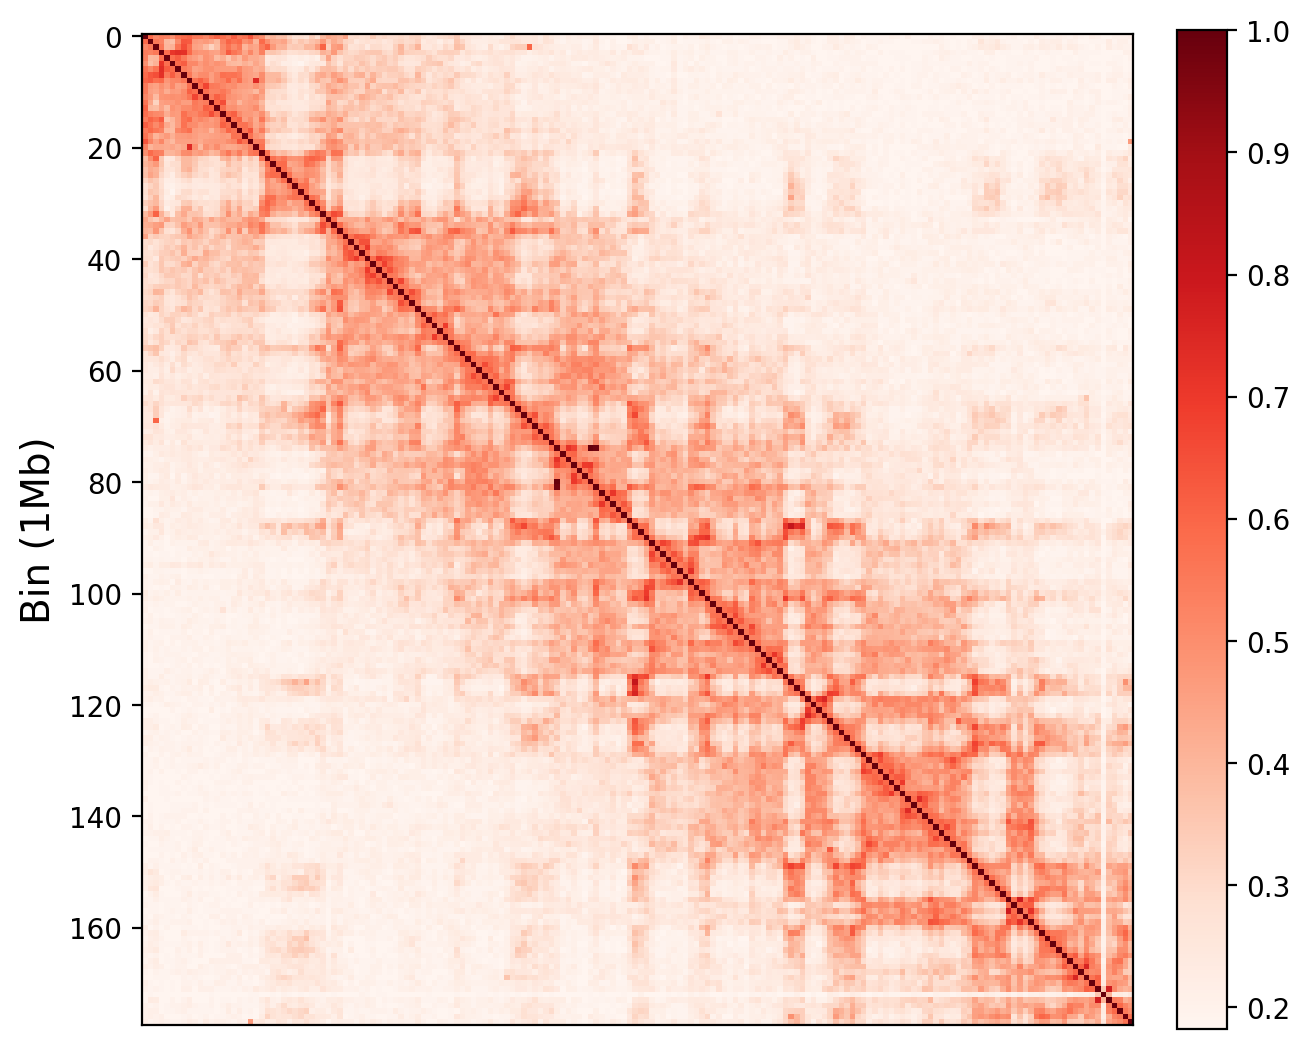

In [79]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

plotPx = pcu.dropZeroRows(pXNorm, threshold=35)
print(plotPx.shape)

plt.imshow(plotPx, cmap='Reds', vmin=plotPx.min(), vmax=plotPx.max())
plt.colorbar(fraction=0.046, pad=0.04)
# plt.title('Frequency of Observation')
plt.ylabel("Bin (1Mb)", fontsize=14)
plt.xticks([], [])
# plt.yticks([], [])

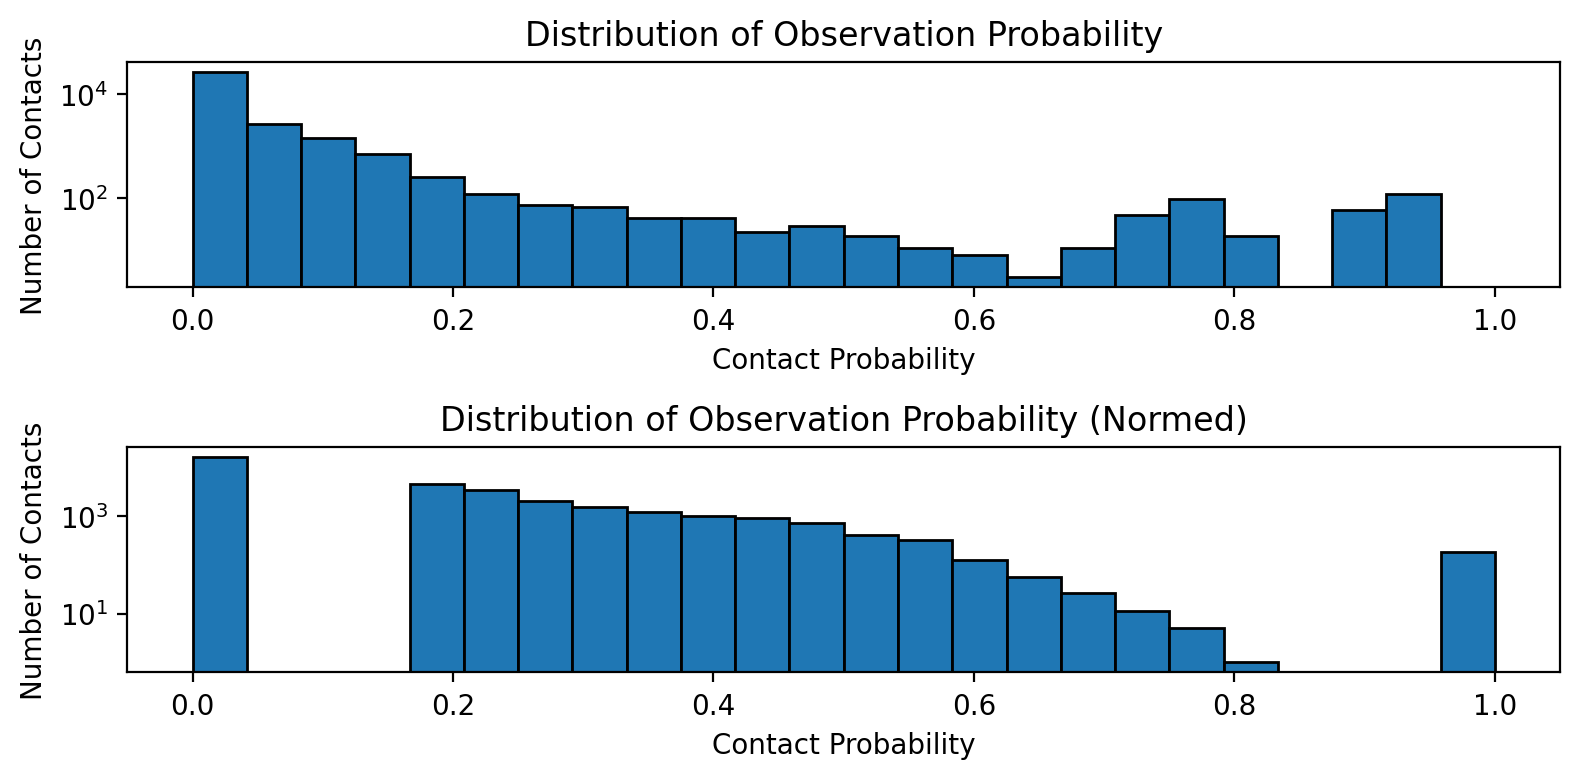

In [12]:
probs = np.tril(pX)
probsNormed = np.tril(pXNorm)

nBins = 25
histBins = np.linspace(0, 1, nBins)

plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = 8, 4

fig = plt.figure()
fig.add_subplot(2, 1, 1)

t = plt.hist(probs.ravel(),
            edgecolor='k',
            bins=histBins)
plt.xlabel('Contact Probability')
plt.ylabel('Number of Contacts')
plt.yscale('log')
plt.title('Distribution of Observation Probability')


fig.add_subplot(2, 1, 2)

t = plt.hist(probsNormed.ravel(),
            edgecolor='k',
            bins=histBins)
plt.xlabel('Contact Probability')
plt.ylabel('Number of Contacts')
plt.yscale('log')
plt.title('Distribution of Observation Probability (Normed)')

plt.tight_layout()

In [13]:
# construct adjacent vs expanded binary martcies for each cell

mats = {}

for runId, data in chrom2.items():
    
    adj = data['adjacent']
    exp = data['expanded']
    
    
    indicatorMat = adj.copy()
    indicatorMat = np.where((exp == 1) & (indicatorMat != 1), 2, indicatorMat)
        
    zeroEntries = indicatorMat[indicatorMat == 0].size
    adjOnly = indicatorMat[indicatorMat == 1].size
    cliqOnly = indicatorMat[indicatorMat == 2].size
    n = indicatorMat.size
    
    print(f"{runId=} {zeroEntries=} ({zeroEntries/n:.3f}) {adjOnly=} ({adjOnly/n:.3f}) {cliqOnly=} ({cliqOnly/n:.3f})")

    mats[runId] = indicatorMat
    
print('done.')

runId='run01' zeroEntries=32096 (0.969) adjOnly=842 (0.025) cliqOnly=186 (0.006)
runId='run02' zeroEntries=32006 (0.966) adjOnly=792 (0.024) cliqOnly=326 (0.010)
runId='run04' zeroEntries=32518 (0.982) adjOnly=510 (0.015) cliqOnly=96 (0.003)
runId='run05' zeroEntries=32246 (0.973) adjOnly=690 (0.021) cliqOnly=188 (0.006)
runId='run06' zeroEntries=32296 (0.975) adjOnly=666 (0.020) cliqOnly=162 (0.005)
runId='run07' zeroEntries=32066 (0.968) adjOnly=808 (0.024) cliqOnly=250 (0.008)
done.


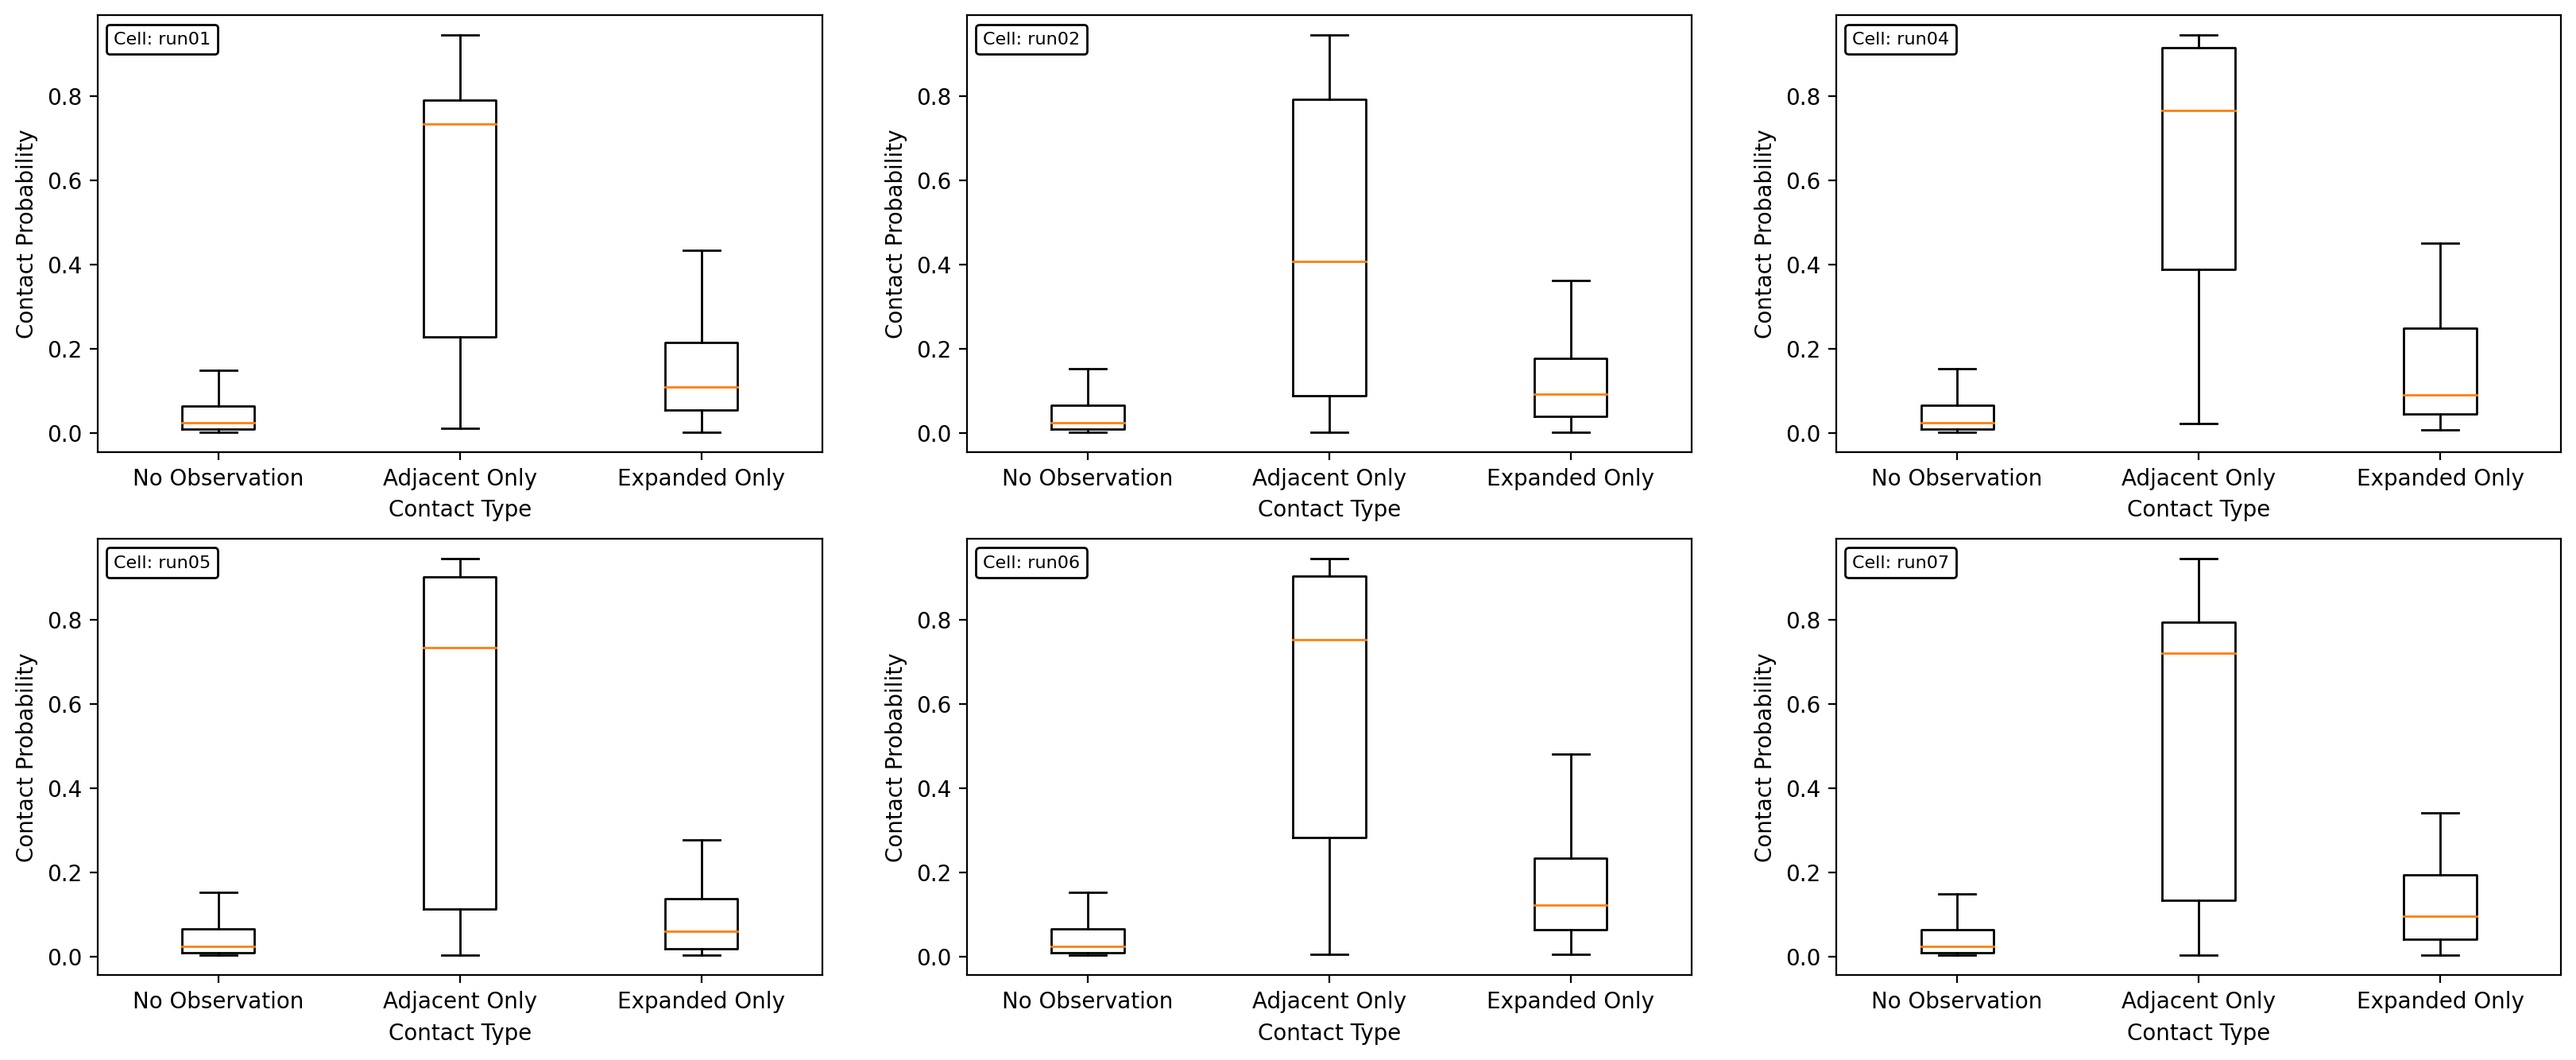

In [14]:
# test for means

plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = 20, 8

fig = plt.figure()

pltNum = 0
for runId, A in mats.items():
    pltNum += 1
    noObs =  np.where(A == 0, pX, 0)
    adjOnly = np.where(A == 1, pX, 0)
    expOnly = np.where(A == 2, pX, 0)
    
    # remove zero value entries, they shouldn't be considered
    noObs = noObs[noObs > 0]
    adjOnly = adjOnly[adjOnly > 0]
    expOnly = expOnly[expOnly > 0]
    
    fig.add_subplot(2,3,pltNum)
    
    plt.boxplot([noObs, adjOnly, expOnly],
                labels = ['No Observation', 'Adjacent Only', 'Expanded Only'],
                showfliers=False)

    ax = plt.gca()
    at = AnchoredText(
        f"Cell: {runId}", prop=dict(size=8), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.ylabel('Contact Probability')
    plt.xlabel('Contact Type')
plt.show()


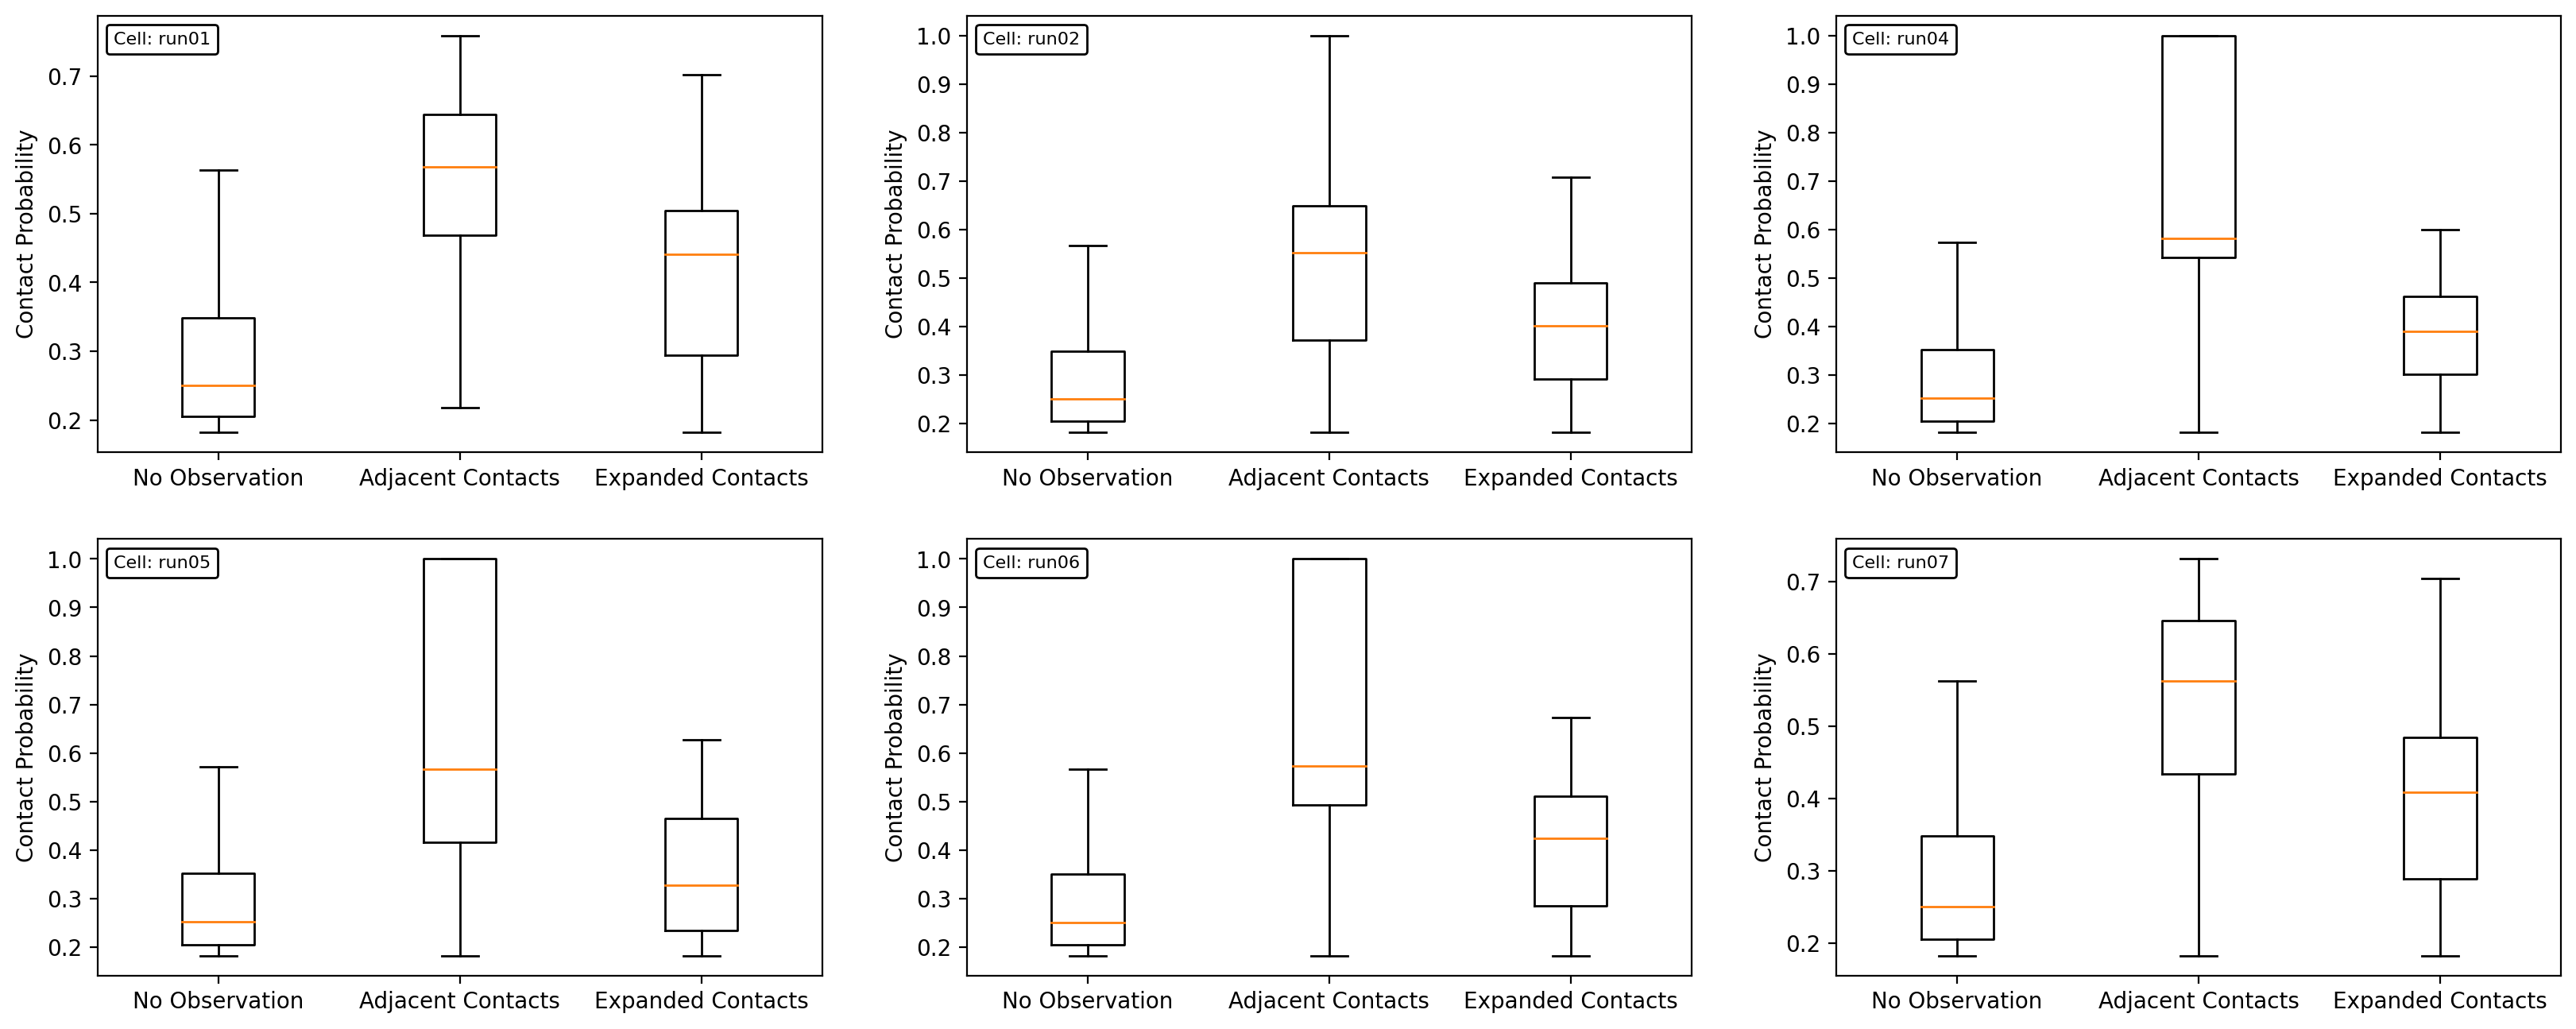

<Figure size 4000x1600 with 0 Axes>

In [15]:
# test for means

plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = 20, 8

fig = plt.figure()

pltNum = 0
for runId, A in mats.items():
    pltNum += 1
    noObs =  np.where(A == 0, pXNorm, 0)
    adjOnly = np.where(A == 1, pXNorm, 0)
    expOnly = np.where(A == 2, pXNorm, 0)
    
    # remove zero value entries, they shouldn't be considered
    noObs = noObs[noObs > 0]
    adjOnly = adjOnly[adjOnly > 0]
    expOnly = expOnly[expOnly > 0]
    
    fig.add_subplot(2,3,pltNum)
    
    plt.boxplot([noObs, adjOnly, expOnly],
                labels = ['No Observation', 'Adjacent Contacts', 'Expanded Contacts'],
                showfliers=False)

    ax = plt.gca()
    at = AnchoredText(
        f"Cell: {runId}", prop=dict(size=8), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.ylabel('Contact Probability')
#     plt.xlabel('Contact Type')
plt.show()
plt.tight_layout()


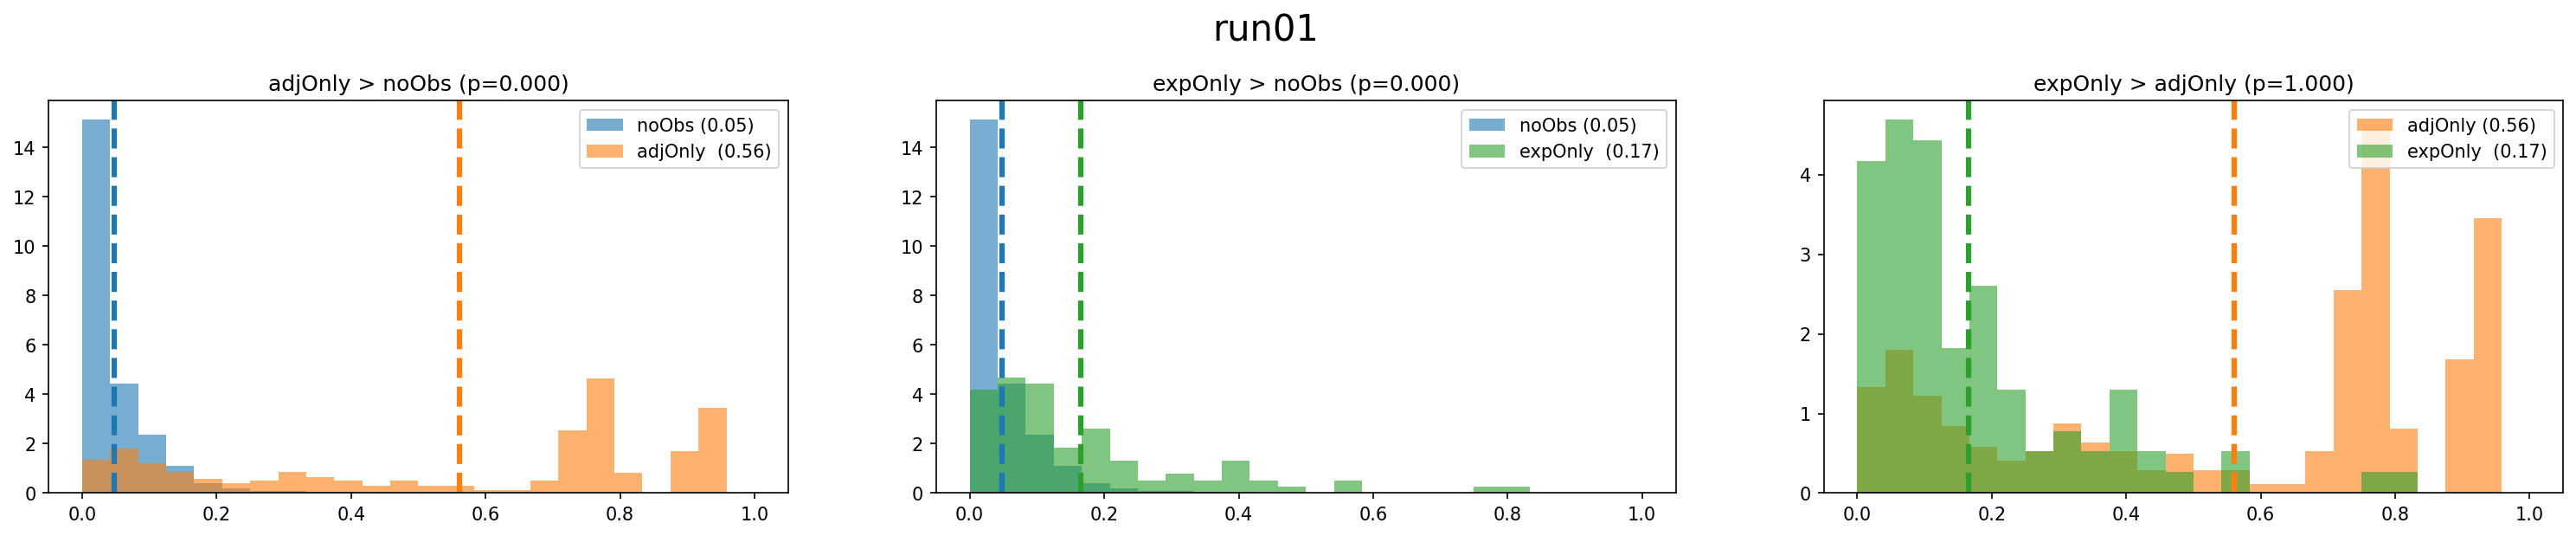

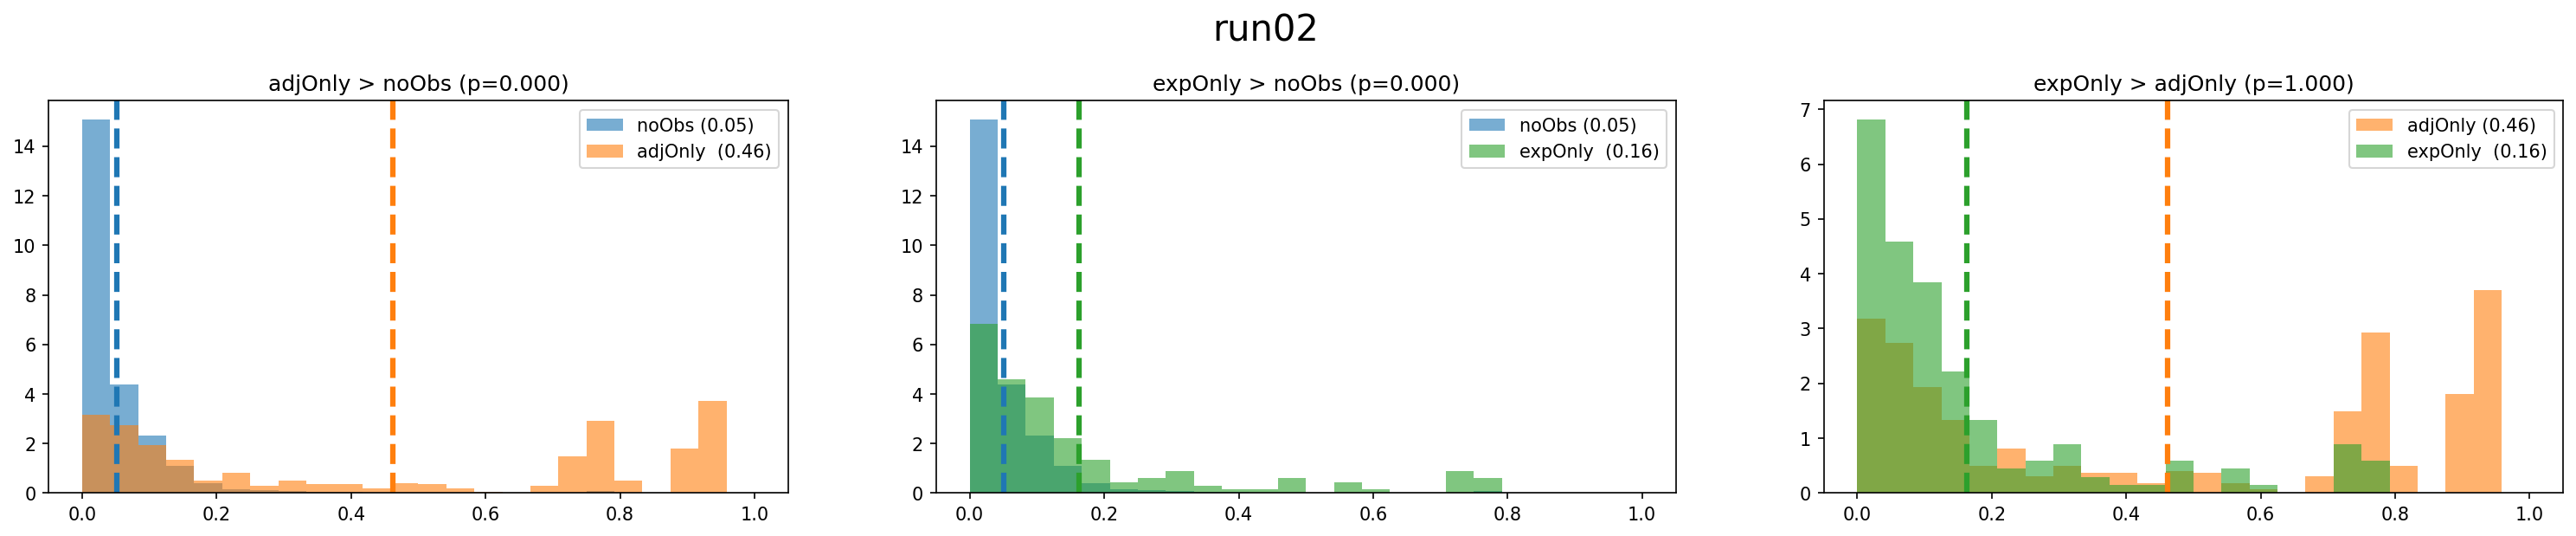

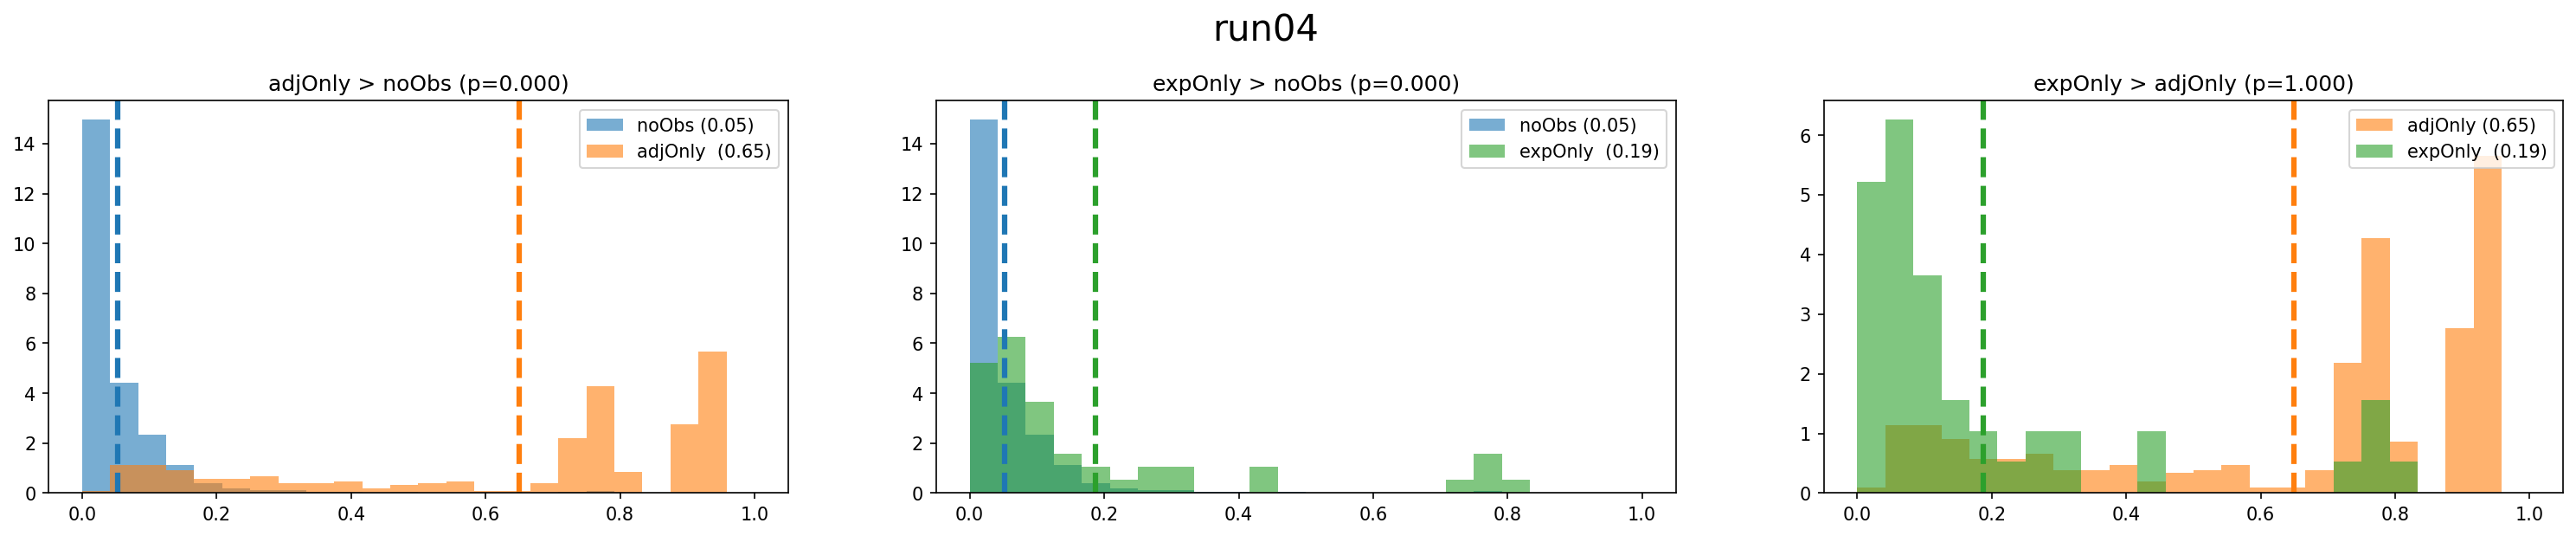

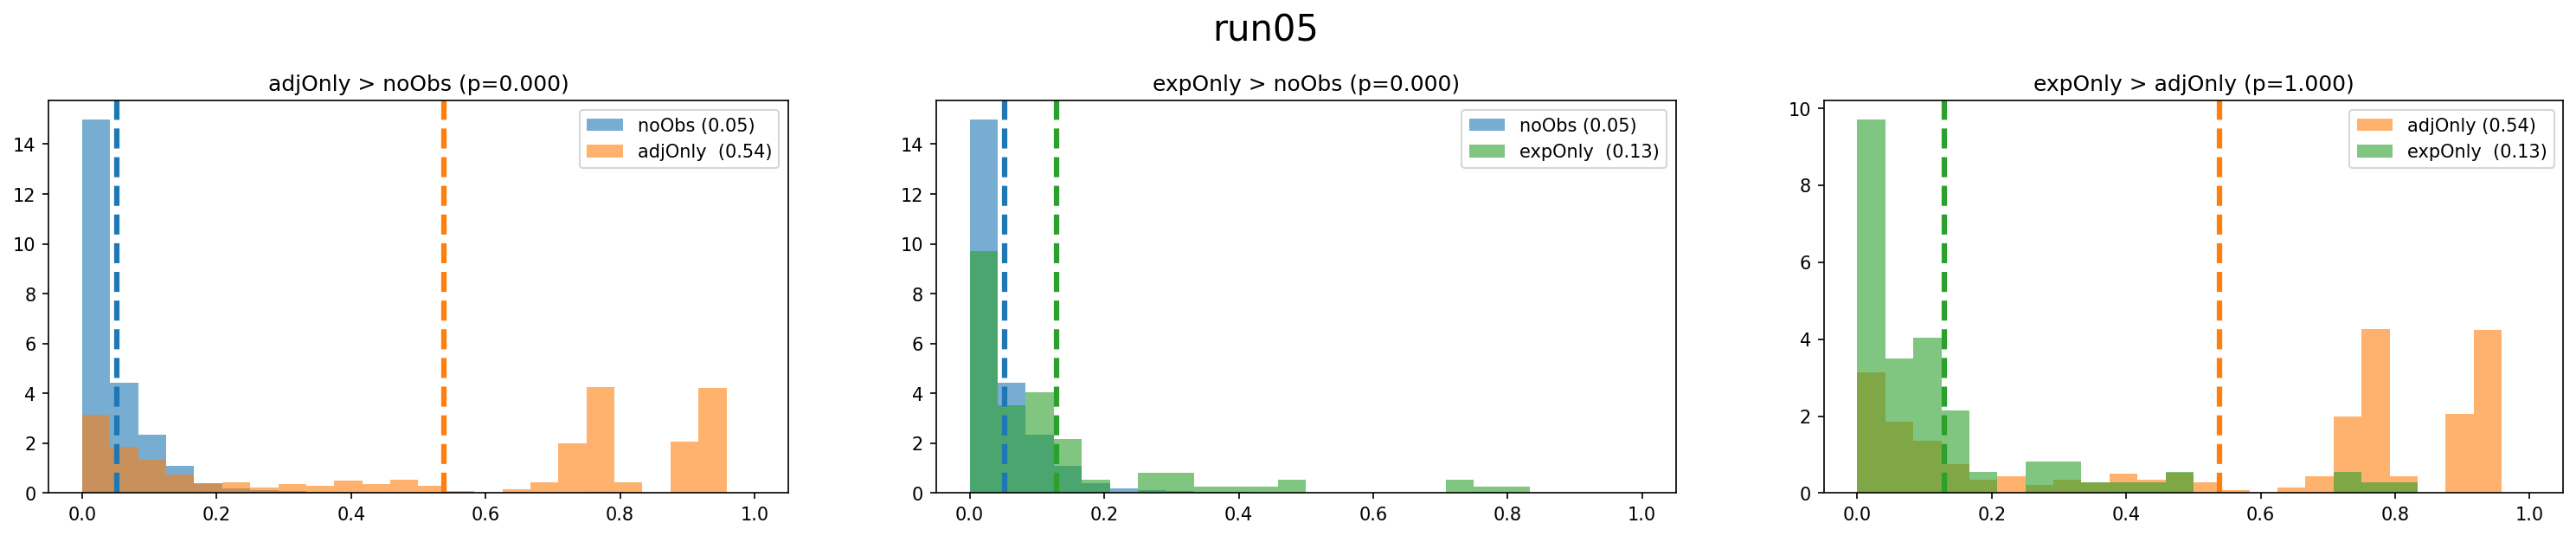

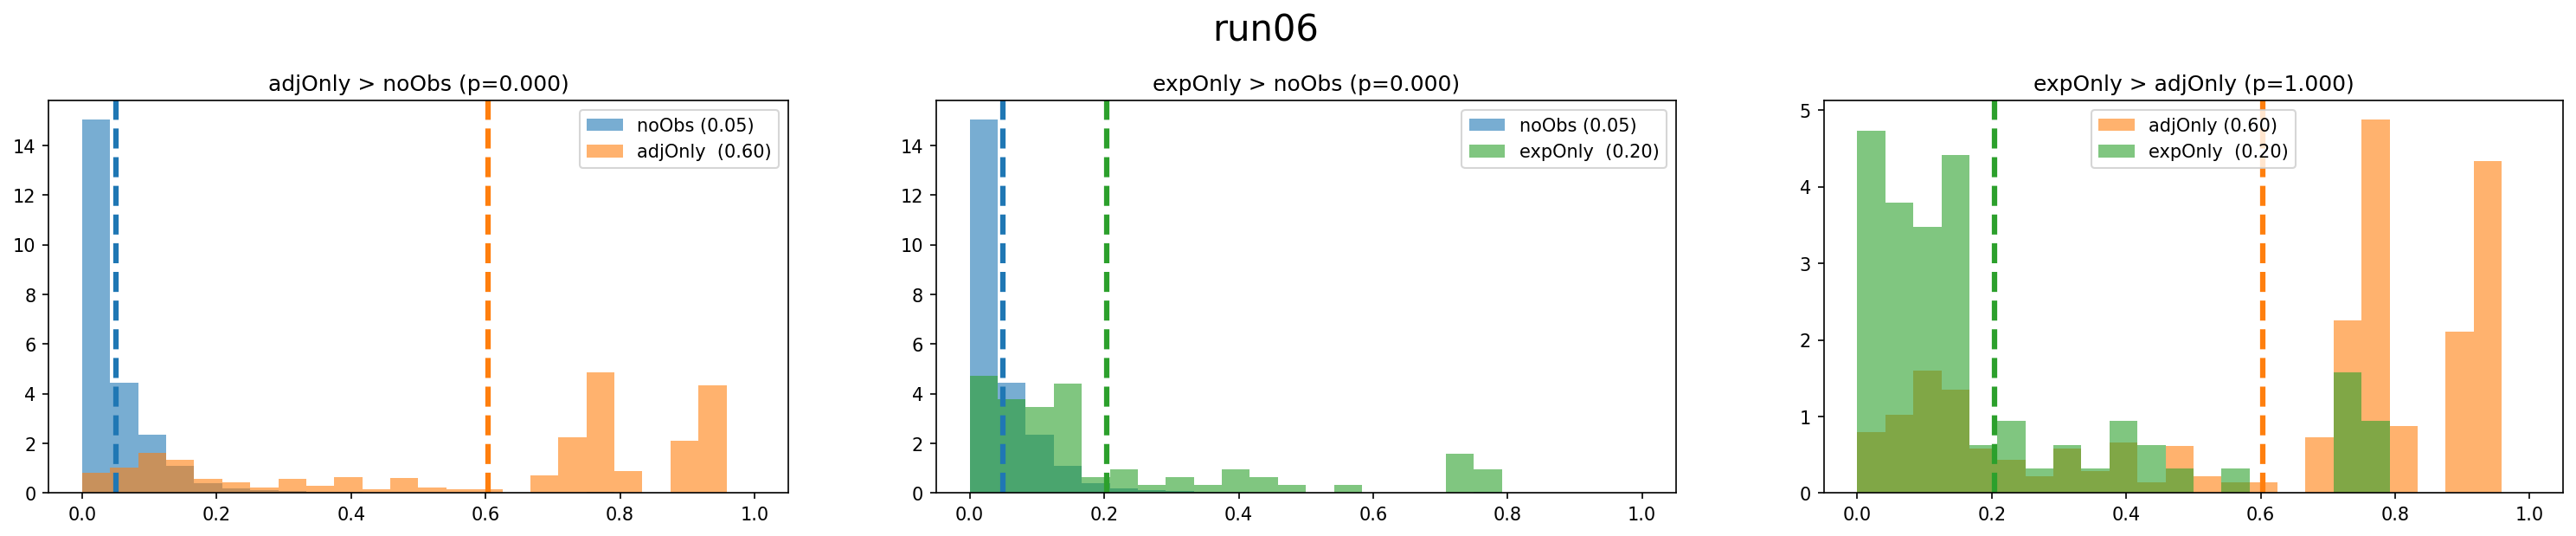

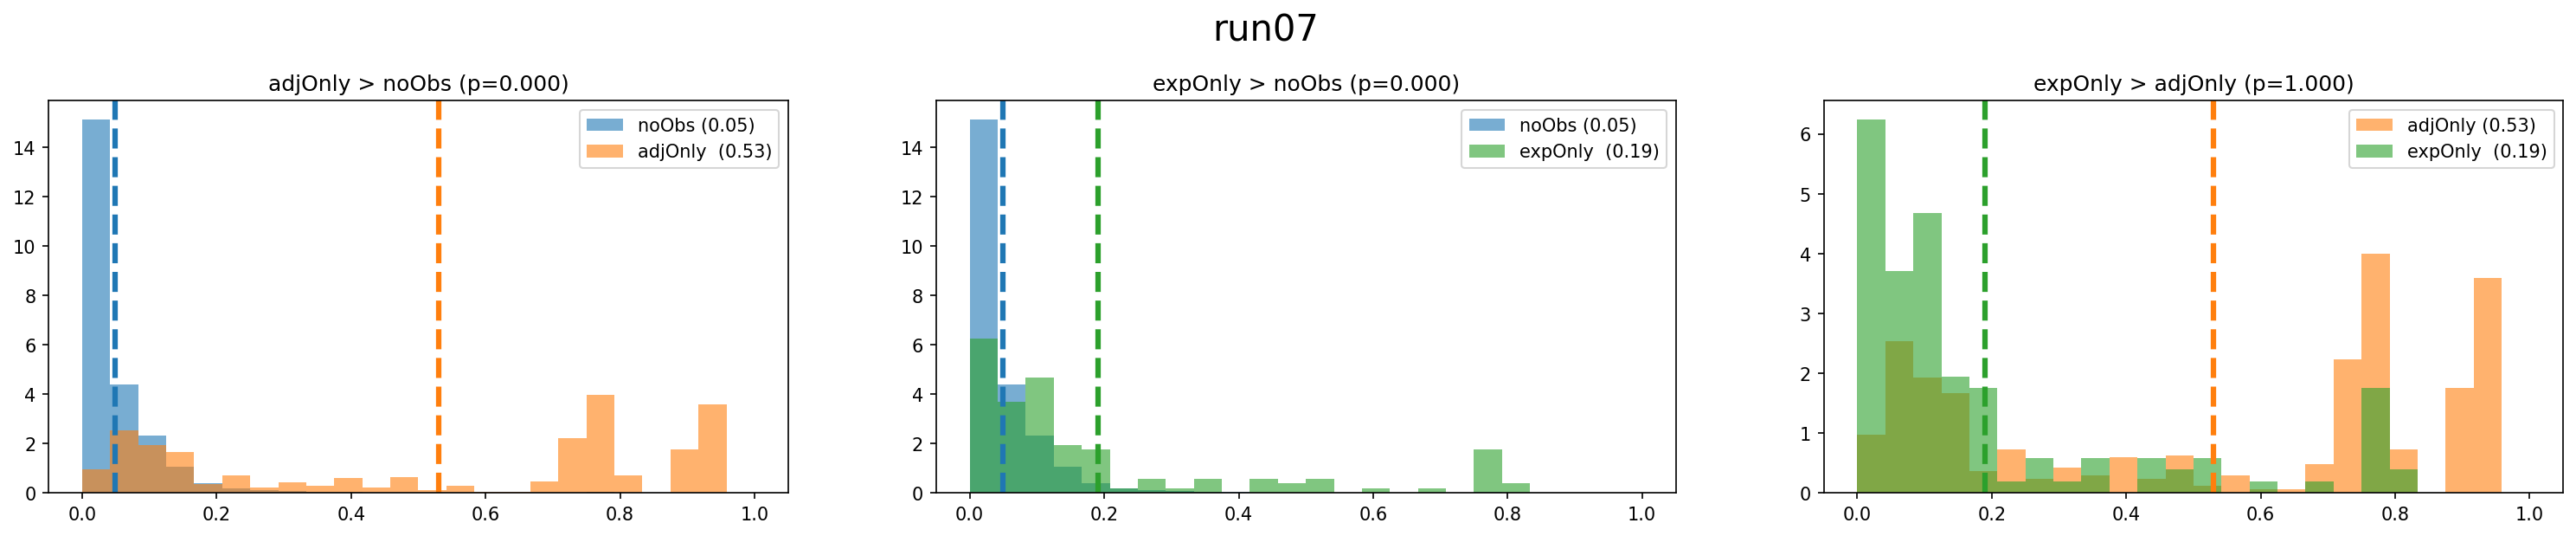

In [63]:

for runId, A in mats.items():
    
#     print(f"{runId=}")

    noObs =  np.where(A == 0, pX, 0)
    adjOnly = np.where(A == 1, pX, 0)
    expOnly = np.where(A == 2, pX, 0)
    
    # remove zero value entries, they shouldn't be considered
    noObs = noObs[noObs > 0]
    adjOnly = adjOnly[adjOnly > 0]
    expOnly = expOnly[expOnly > 0]
    
    conds = {
        'noObs' : noObs,
        'adjOnly' : adjOnly,
        'expOnly' : expOnly,
    }
    
    colors = {
        'noObs' : "C0",
        'adjOnly' : "C1",
        'expOnly' : "C2",
    }
    
    tests = list(combinations(conds, 2))
    
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['figure.figsize'] = 25, 4
    fig = plt.figure()
    
    for figNum, (i, j) in enumerate(tests):
        
        t1 = conds[i]
        t2 = conds[j]
        
        t, p = stats.ttest_ind(t2, t1, 
                               equal_var=False, 
                               alternative='greater',
                               permutations=1000)

        
        nBins = 25
        histBins = np.linspace(0, 1, nBins)
        fig.add_subplot(1, 3, figNum+1)
        
        meant1 = np.mean(t1)
        meant2 = np.mean(t2)
        
        plt.axvline(x=meant1, ls='--', lw=3, color=colors[i])
        plt.axvline(x=meant2, ls='--', lw=3, color=colors[j])
        
        plt.hist(t1, density=True, 
                 bins=histBins, 
                 alpha=0.6, 
                 label=f'{i} ({meant1:.2f})', 
                 color=colors[i])
        
        plt.hist(t2, density=True, 
                 bins=histBins, 
                 alpha=0.6, 
                 label=f'{j}  ({meant2:.2f})', 
                 color=colors[j])
        
        plt.legend()
        plt.title(f"{j} > {i} (p={p:.3f})")
        
    plt.suptitle(f'{runId}', fontsize=20, y=1.05)
#     plt.show()

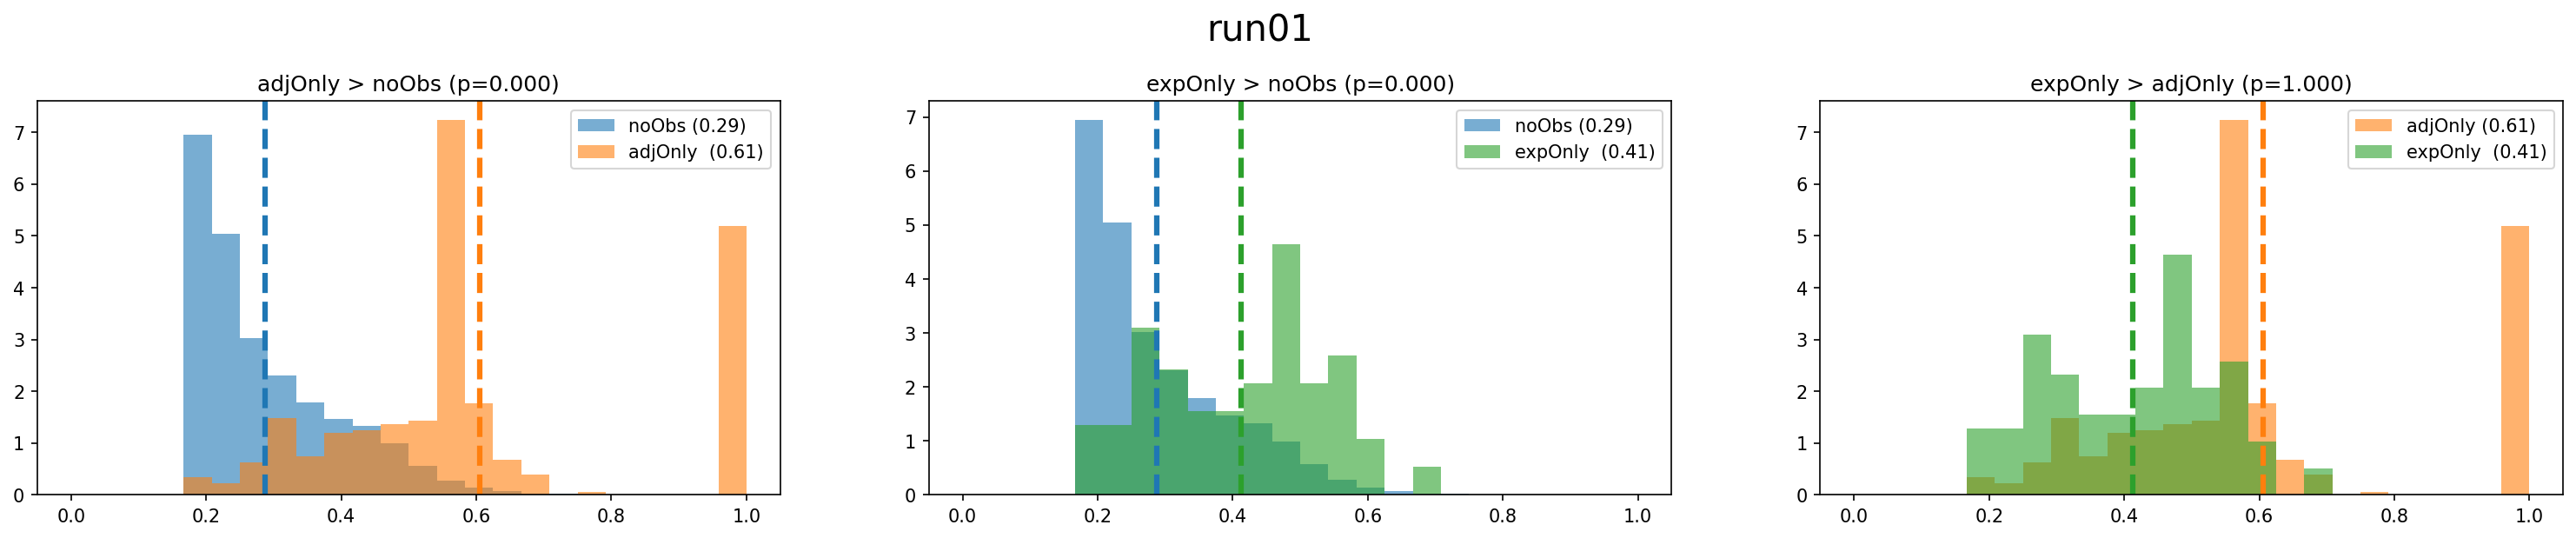

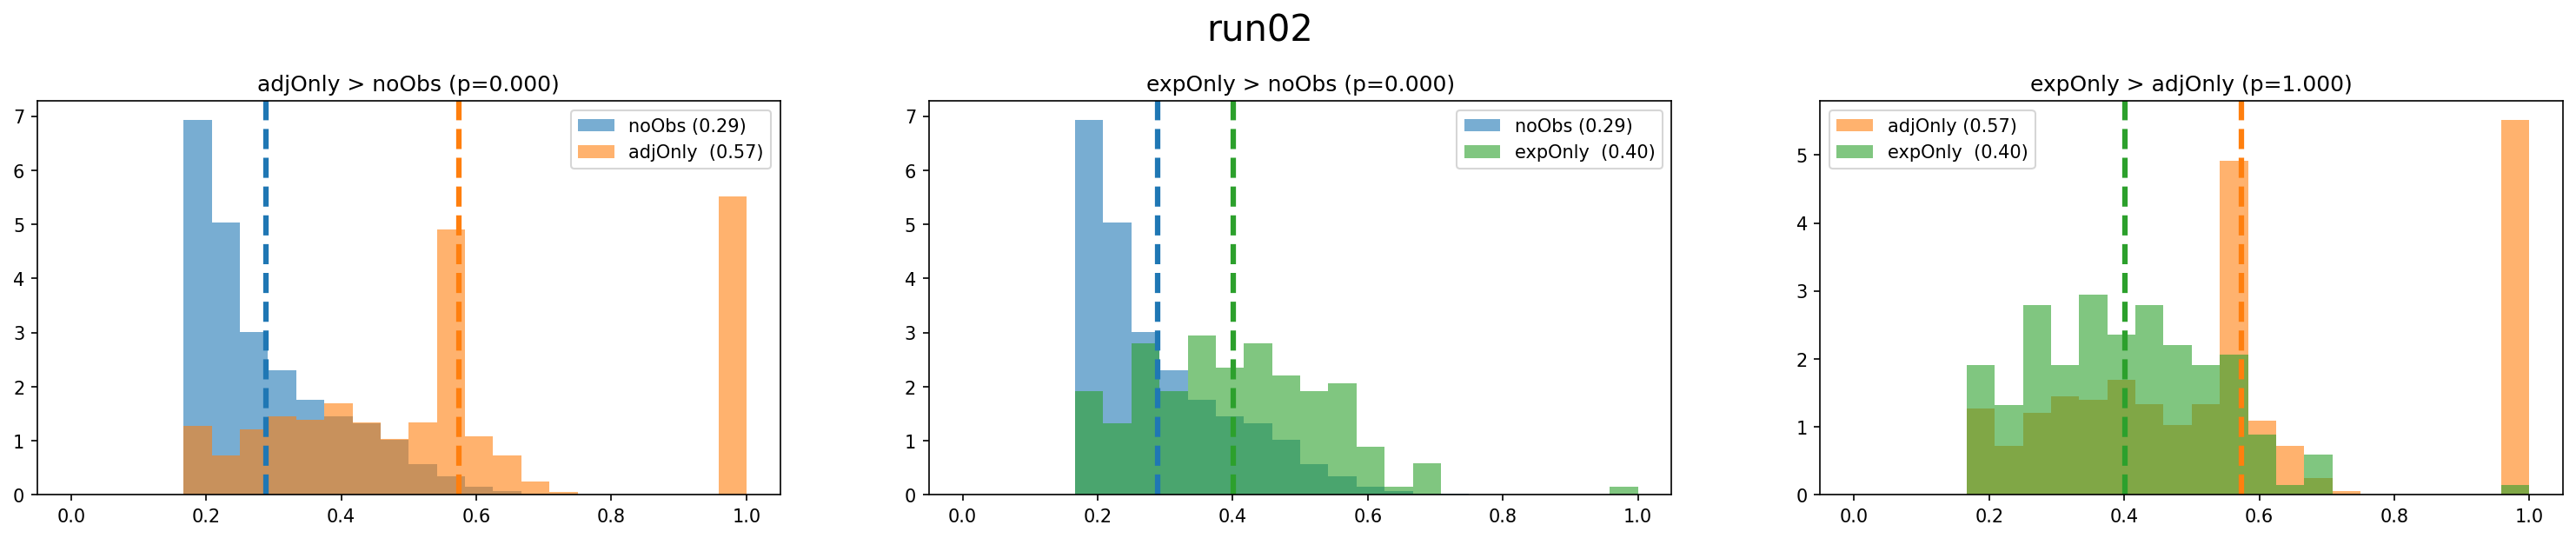

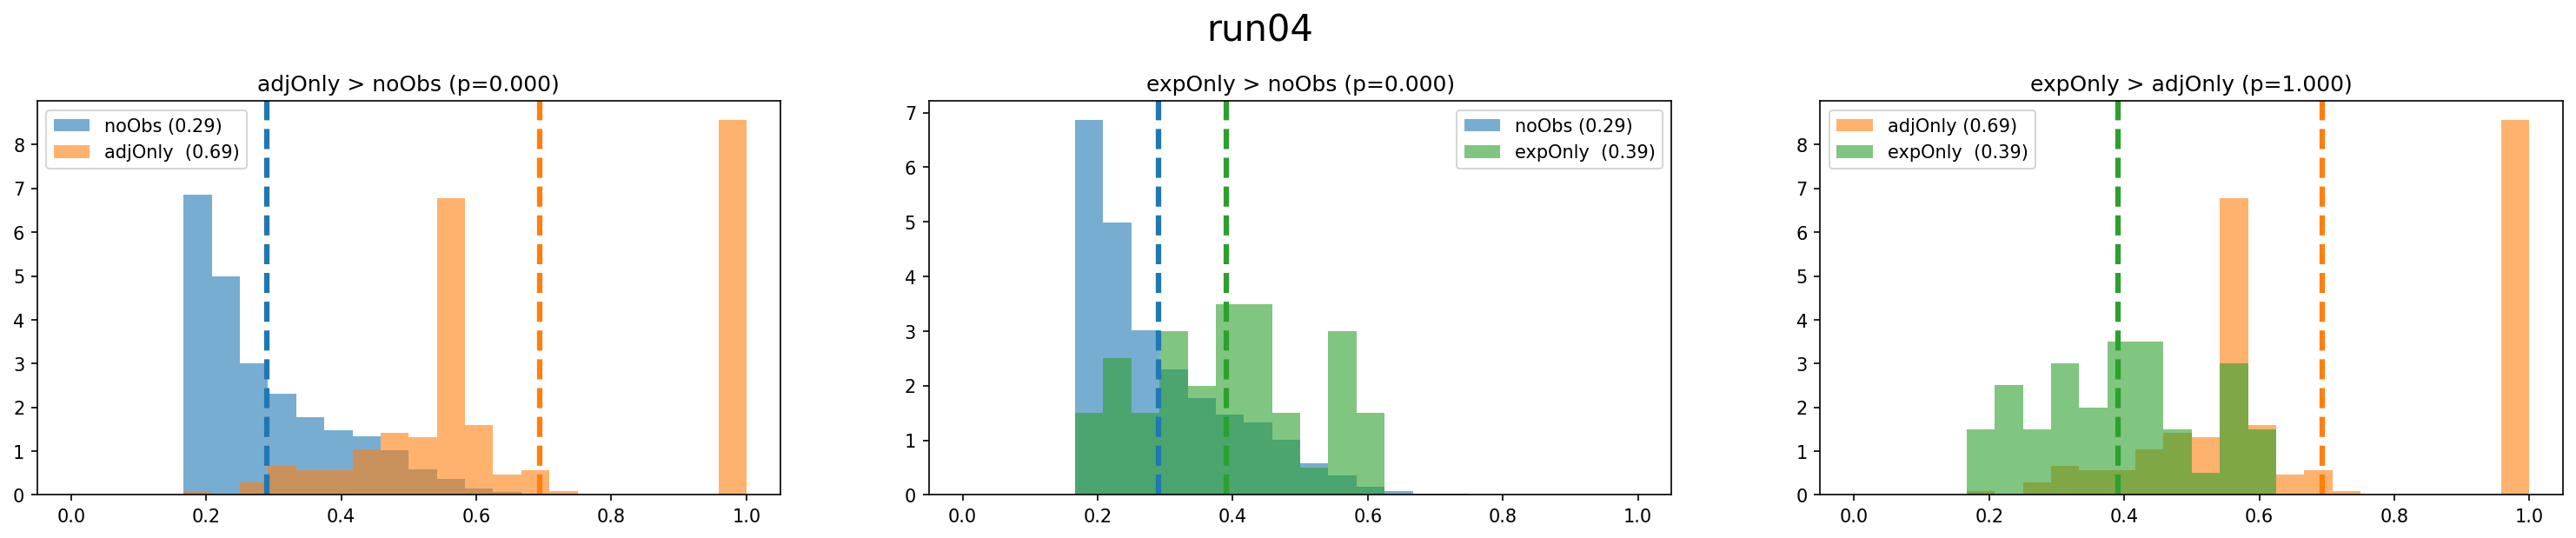

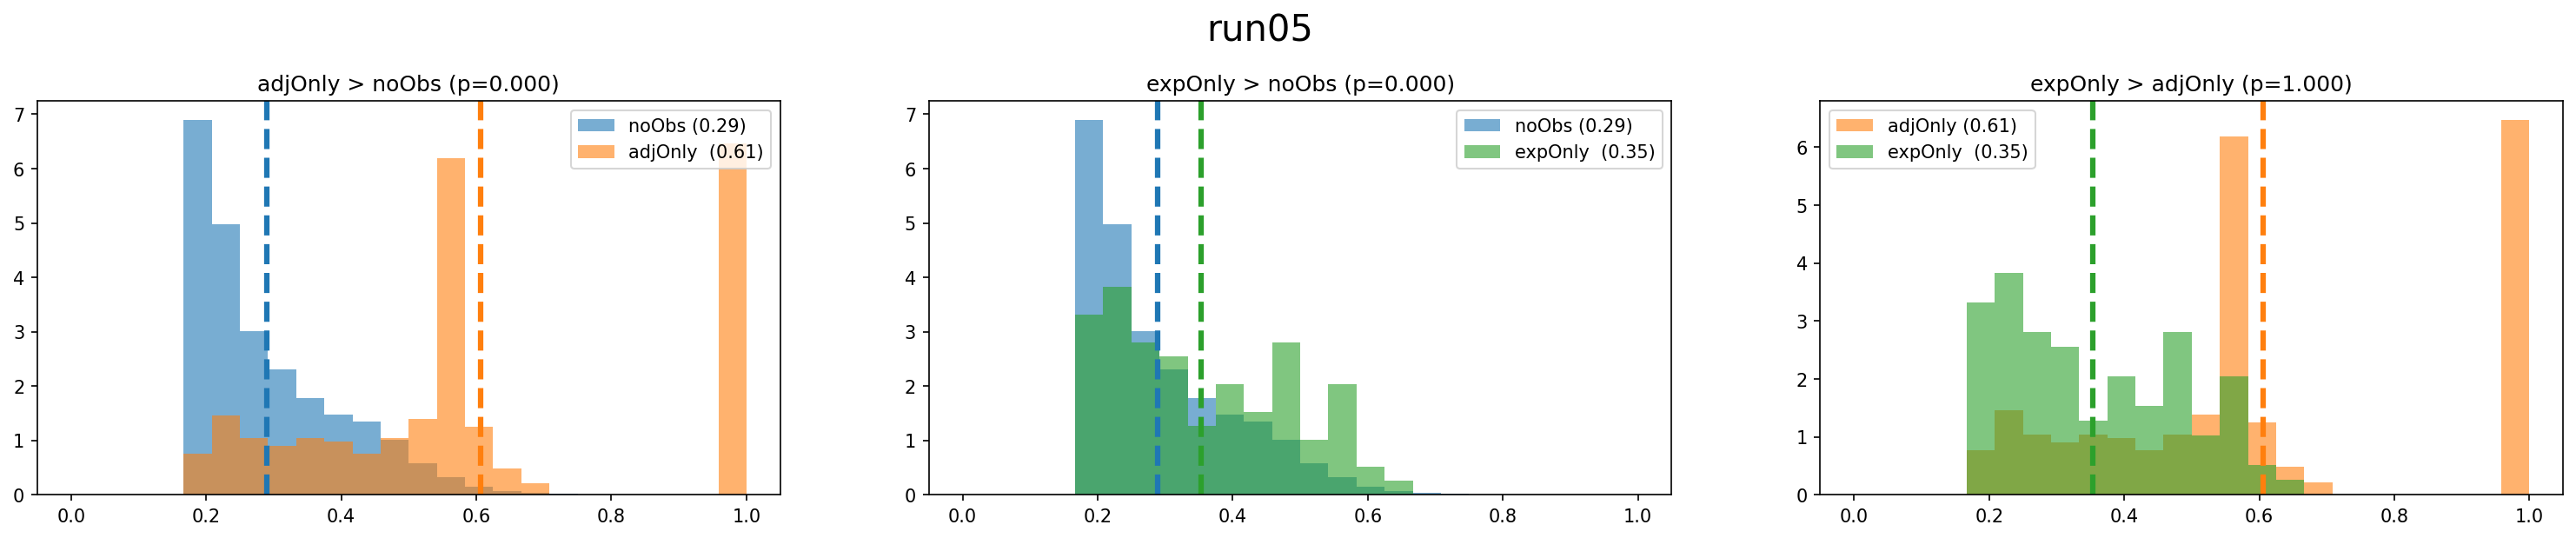

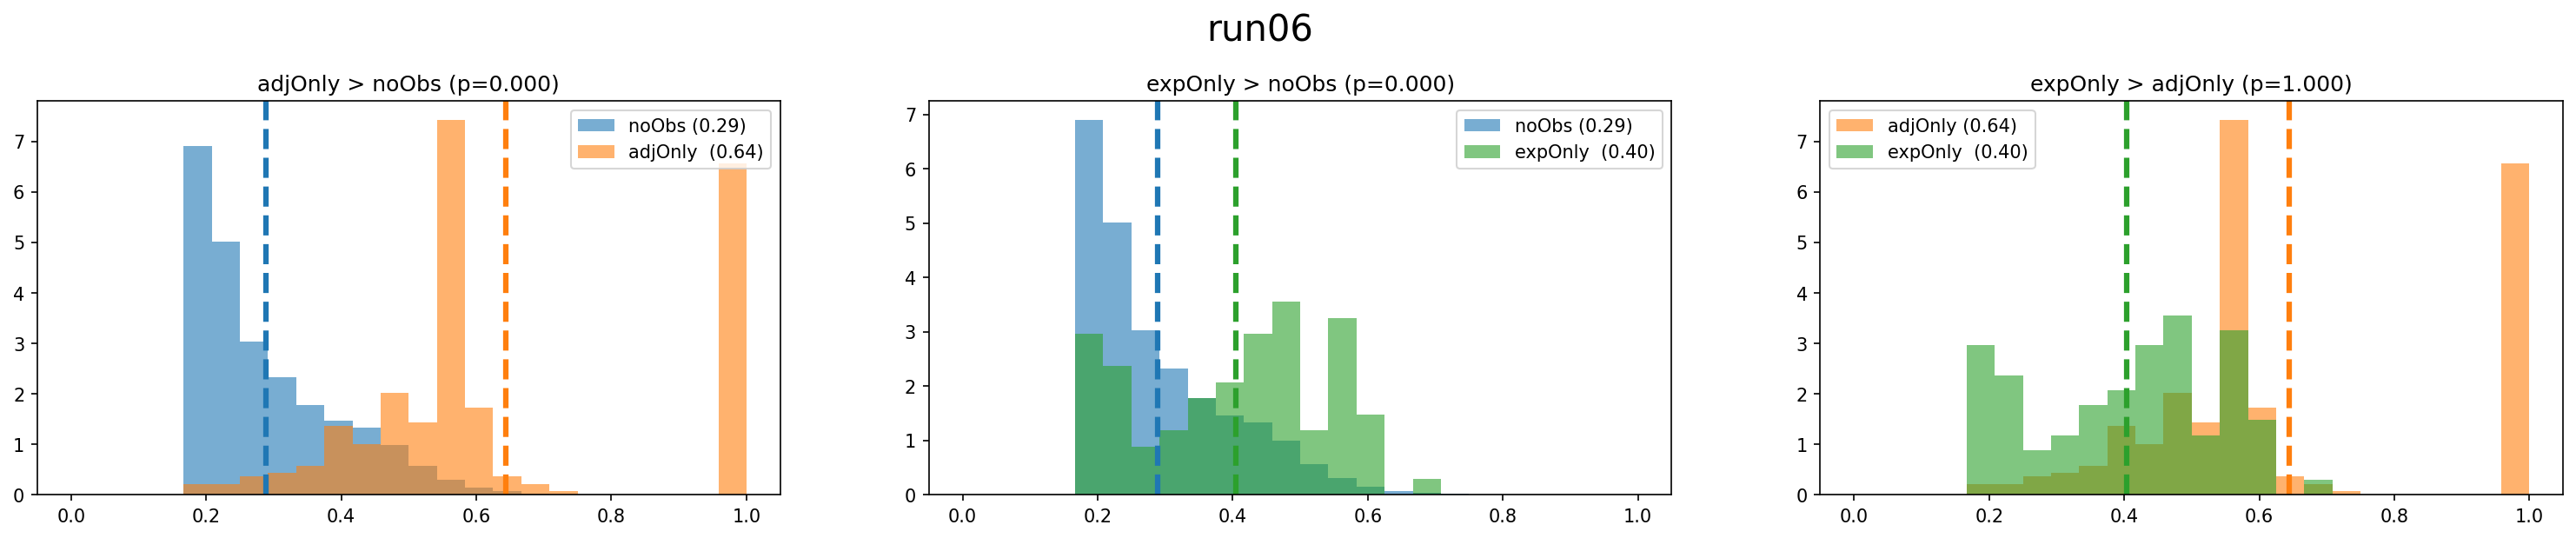

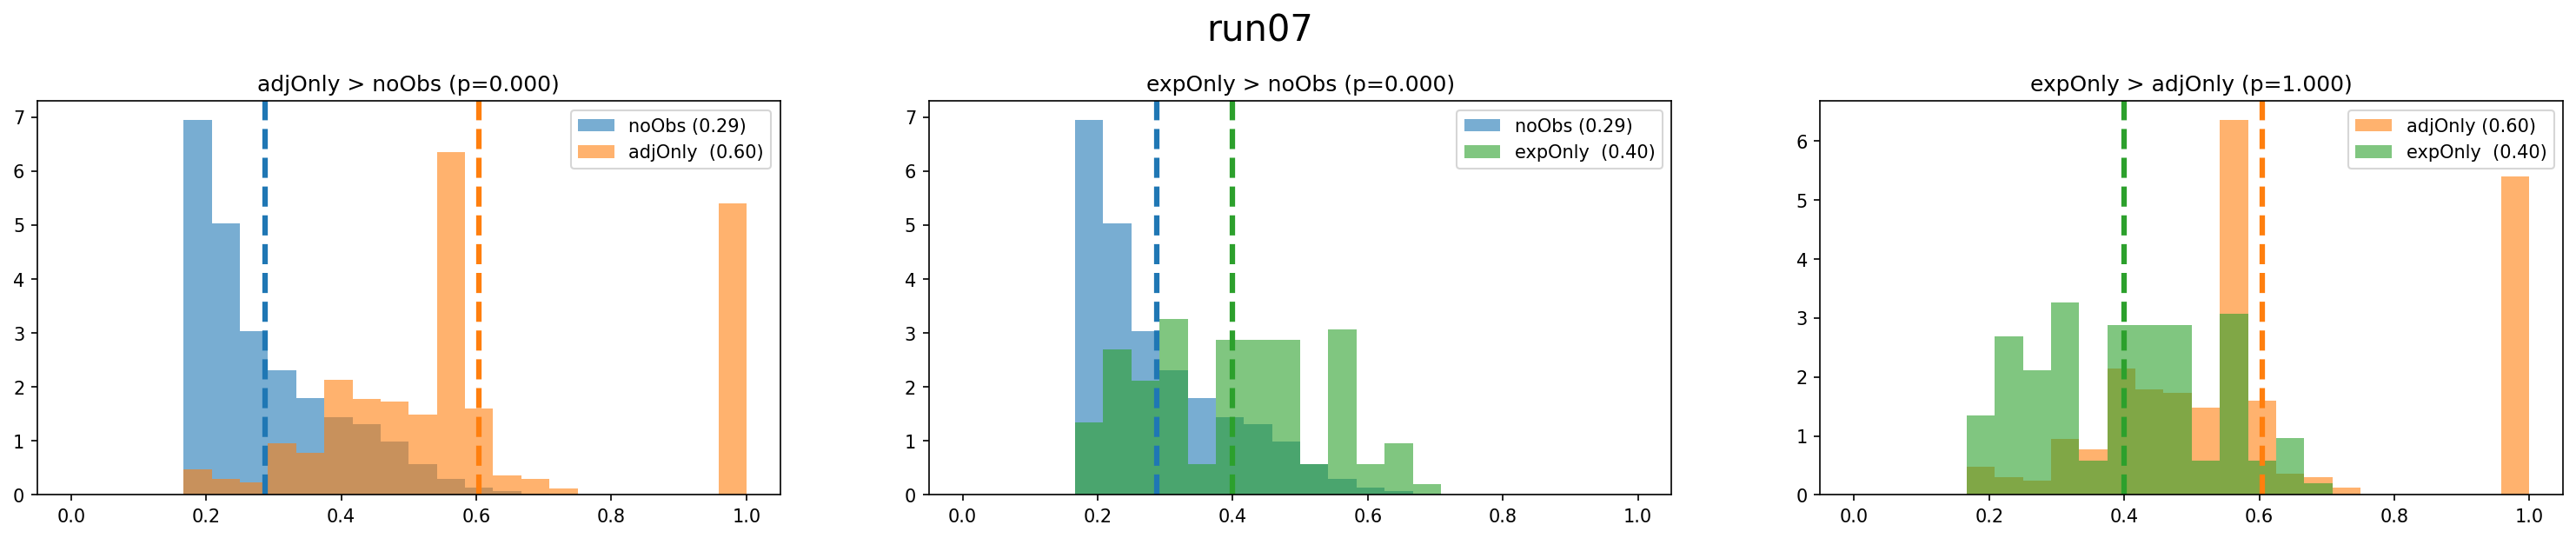

In [64]:

for runId, A in mats.items():
    
#     print(f"{runId=}")

    noObs =  np.where(A == 0, pXNorm, 0)
    adjOnly = np.where(A == 1, pXNorm, 0)
    expOnly = np.where(A == 2, pXNorm, 0)
    
    # remove zero value entries, they shouldn't be considered
    noObs = noObs[noObs > 0]
    adjOnly = adjOnly[adjOnly > 0]
    expOnly = expOnly[expOnly > 0]
    
    conds = {
        'noObs' : noObs,
        'adjOnly' : adjOnly,
        'expOnly' : expOnly,
    }
    
    colors = {
        'noObs' : "C0",
        'adjOnly' : "C1",
        'expOnly' : "C2",
    }
    
    tests = list(combinations(conds, 2))
    
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['figure.figsize'] = 25, 4
    fig = plt.figure()
    
    for figNum, (i, j) in enumerate(tests):
        
        t1 = conds[i]
        t2 = conds[j]
        
        t, p = stats.ttest_ind(t2, t1, 
                               equal_var=False, 
                               alternative='greater',
                               permutations=1000)

        
        nBins = 25
        histBins = np.linspace(0, 1, nBins)
        fig.add_subplot(1, 3, figNum+1)
        
        meant1 = np.mean(t1)
        meant2 = np.mean(t2)
        
        plt.axvline(x=meant1, ls='--', lw=3, color=colors[i])
        plt.axvline(x=meant2, ls='--', lw=3, color=colors[j])
        
        plt.hist(t1, density=True, 
                 bins=histBins, 
                 alpha=0.6, 
                 label=f'{i} ({meant1:.2f})', 
                 color=colors[i])
        
        plt.hist(t2, density=True, 
                 bins=histBins, 
                 alpha=0.6, 
                 label=f'{j}  ({meant2:.2f})', 
                 color=colors[j])
        
        plt.legend()
        plt.title(f"{j} > {i} (p={p:.3f})")
        
    plt.suptitle(f'{runId}', fontsize=20, y=1.05)
#     plt.show()

Text(0.5, 1.0, 'Ensemble of Expanded Contacts')

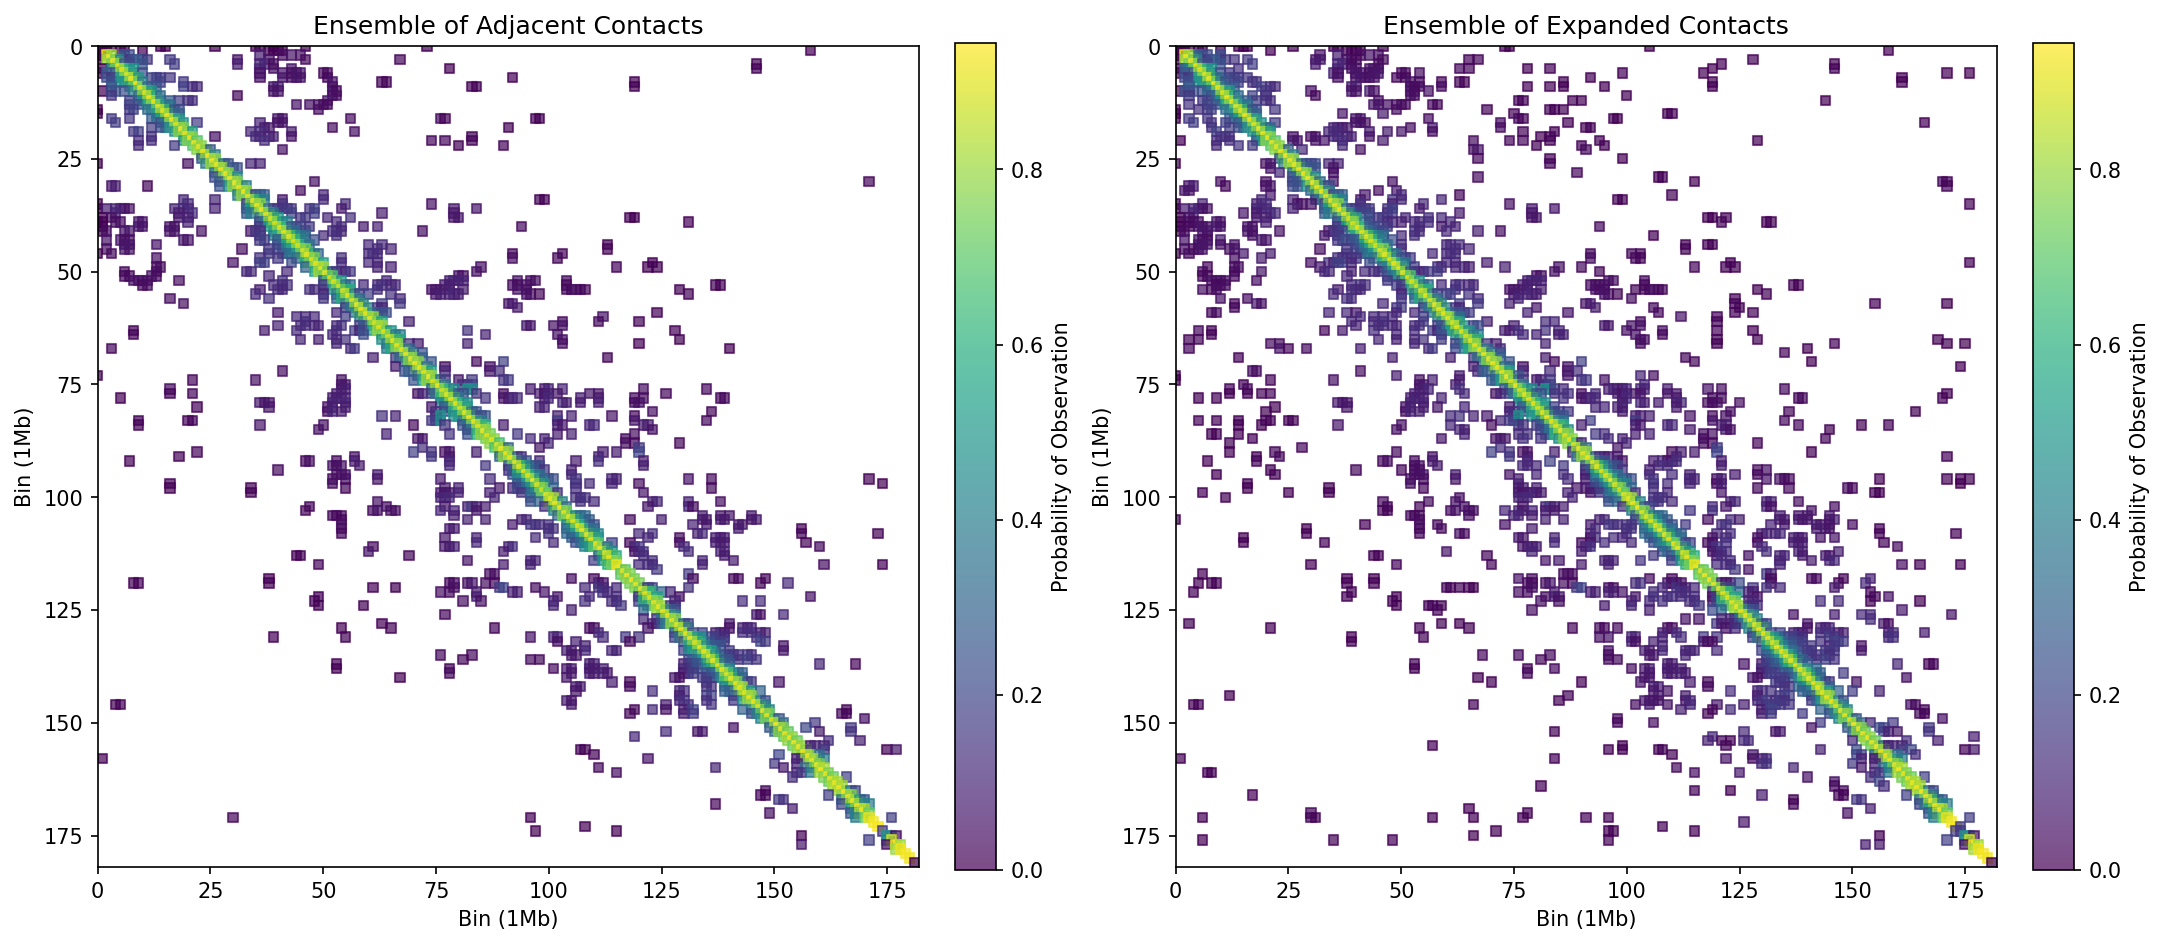

In [18]:
adjEnsemble = np.zeros((182, 182))
expEnsemble = np.zeros((182, 182))

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 17, 17

for runId, data in chrom2.items():
    adj = data['adjacent']
    exp = data['expanded']
    
    adjEnsemble += adj
    expEnsemble += exp
    

adjEnsemble = pcu.Abin(adjEnsemble)
expEnsemble = pcu.Abin(expEnsemble)

fig = plt.figure()
fig.add_subplot(1, 2, 1, aspect='equal')
    
pntsX, pntsY = np.nonzero(adjEnsemble)
color = pX[pntsX, pntsY]

plt.scatter(pntsY, pntsX, 
            marker='s', 
            s=20,
            alpha=0.7, 
            c=color)
plt.gca().invert_yaxis()
plt.colorbar(label='Probability of Observation', fraction=0.046, pad=0.04)
plt.ylim(182, 0)
plt.xlim(0, 182)

plt.xlabel("Bin (1Mb)")
plt.ylabel("Bin (1Mb)")
plt.title('Ensemble of Adjacent Contacts')


fig.add_subplot(1, 2, 2, aspect='equal')

pntsX, pntsY = np.nonzero(expEnsemble)
color = pX[pntsX, pntsY]

plt.scatter(pntsY, pntsX, 
            marker='s', 
            s=20,
            alpha=0.7, 
            c=color)
plt.gca().invert_yaxis()
plt.colorbar(label='Probability of Observation', fraction=0.046, pad=0.04)
plt.ylim(182, 0)
plt.xlim(0, 182)

plt.xlabel("Bin (1Mb)")
plt.ylabel("Bin (1Mb)")
plt.title('Ensemble of Expanded Contacts')


Text(0.5, 1.0, 'Ensemble of Expanded Contacts')

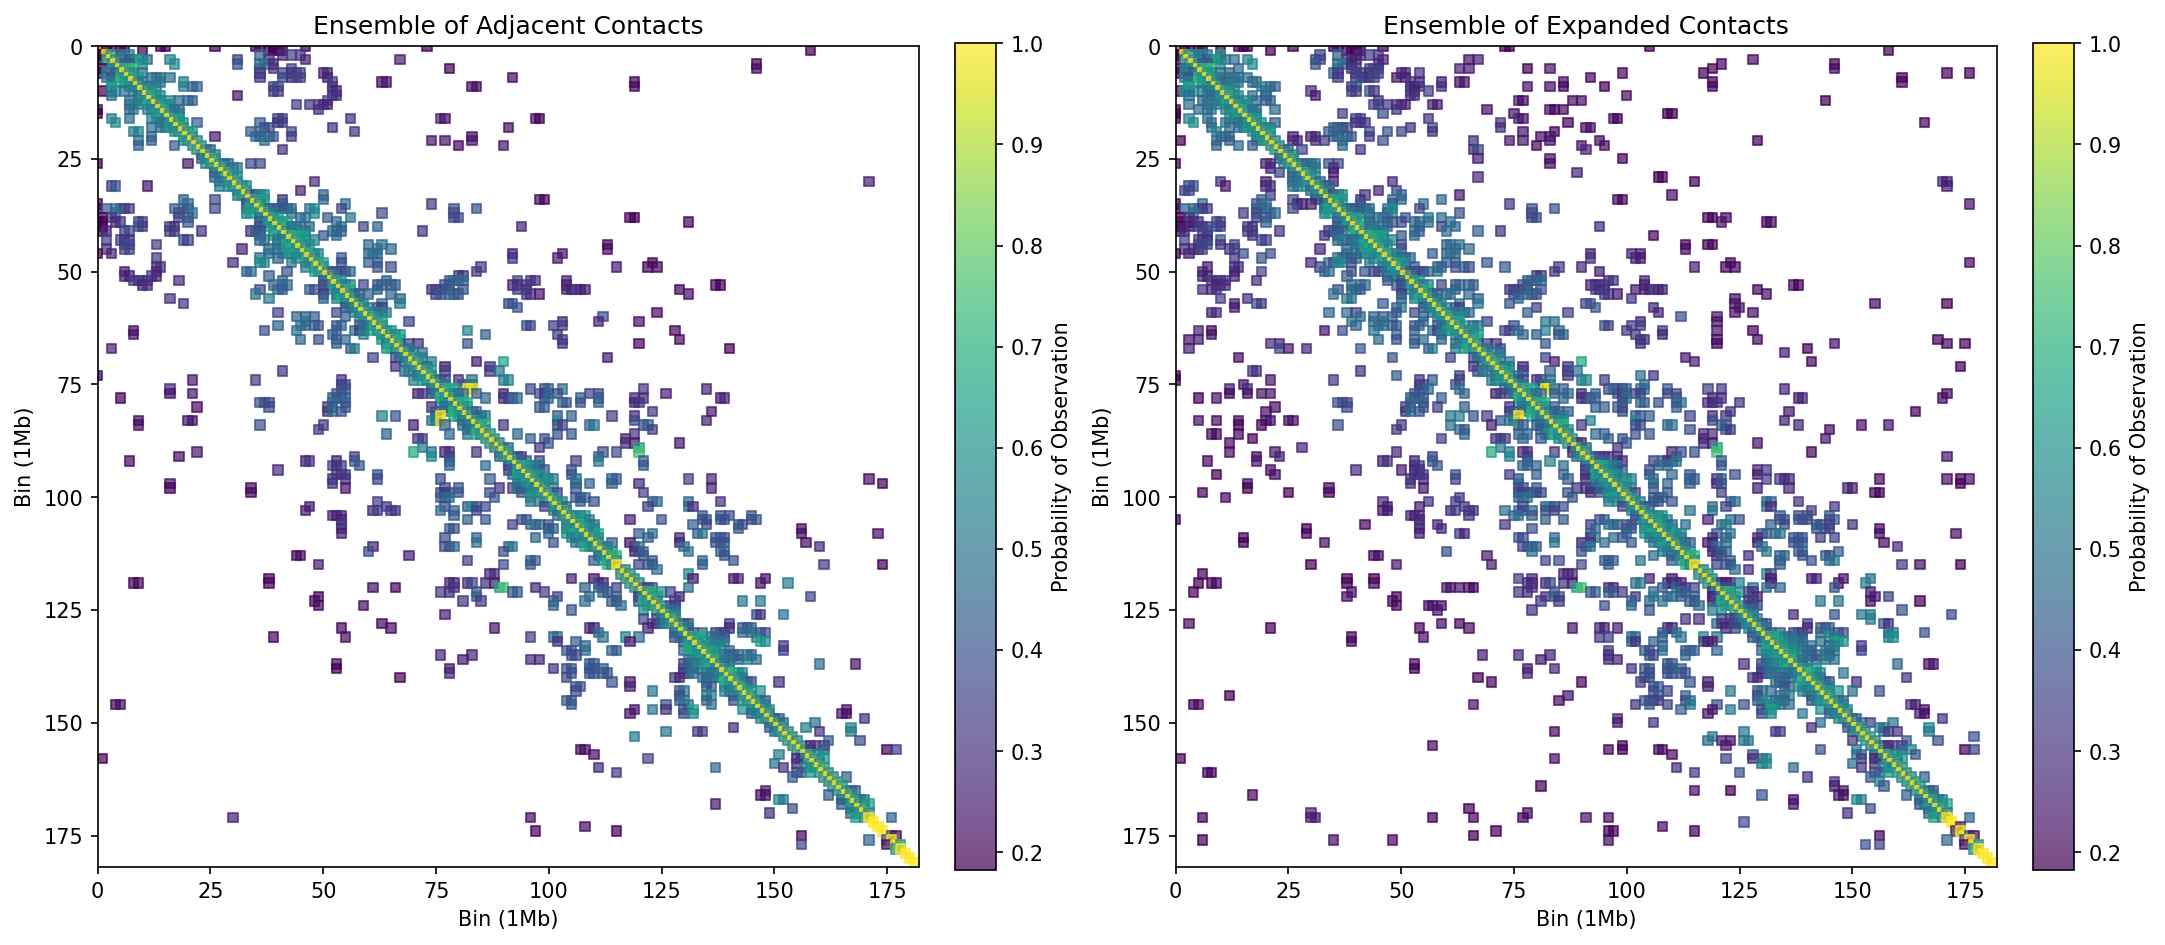

In [19]:
adjEnsemble = np.zeros((182, 182))
expEnsemble = np.zeros((182, 182))

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 17, 17

for runId, data in chrom2.items():
    adj = data['adjacent']
    exp = data['expanded']
    
    adjEnsemble += adj
    expEnsemble += exp
    

adjEnsemble = pcu.Abin(adjEnsemble)
expEnsemble = pcu.Abin(expEnsemble)

fig = plt.figure()
fig.add_subplot(1, 2, 1, aspect='equal')
    
pntsX, pntsY = np.nonzero(adjEnsemble)
color = pXNorm[pntsX, pntsY]

plt.scatter(pntsY, pntsX, 
            marker='s', 
            s=20,
            alpha=0.7, 
            c=color)
plt.gca().invert_yaxis()
plt.colorbar(label='Probability of Observation', fraction=0.046, pad=0.04)
plt.ylim(182, 0)
plt.xlim(0, 182)

plt.xlabel("Bin (1Mb)")
plt.ylabel("Bin (1Mb)")
plt.title('Ensemble of Adjacent Contacts')


fig.add_subplot(1, 2, 2, aspect='equal')

pntsX, pntsY = np.nonzero(expEnsemble)
color = pXNorm[pntsX, pntsY]

plt.scatter(pntsY, pntsX, 
            marker='s', 
            s=20,
            alpha=0.7, 
            c=color)
plt.gca().invert_yaxis()
plt.colorbar(label='Probability of Observation', fraction=0.046, pad=0.04)
plt.ylim(182, 0)
plt.xlim(0, 182)

plt.xlabel("Bin (1Mb)")
plt.ylabel("Bin (1Mb)")
plt.title('Ensemble of Expanded Contacts')


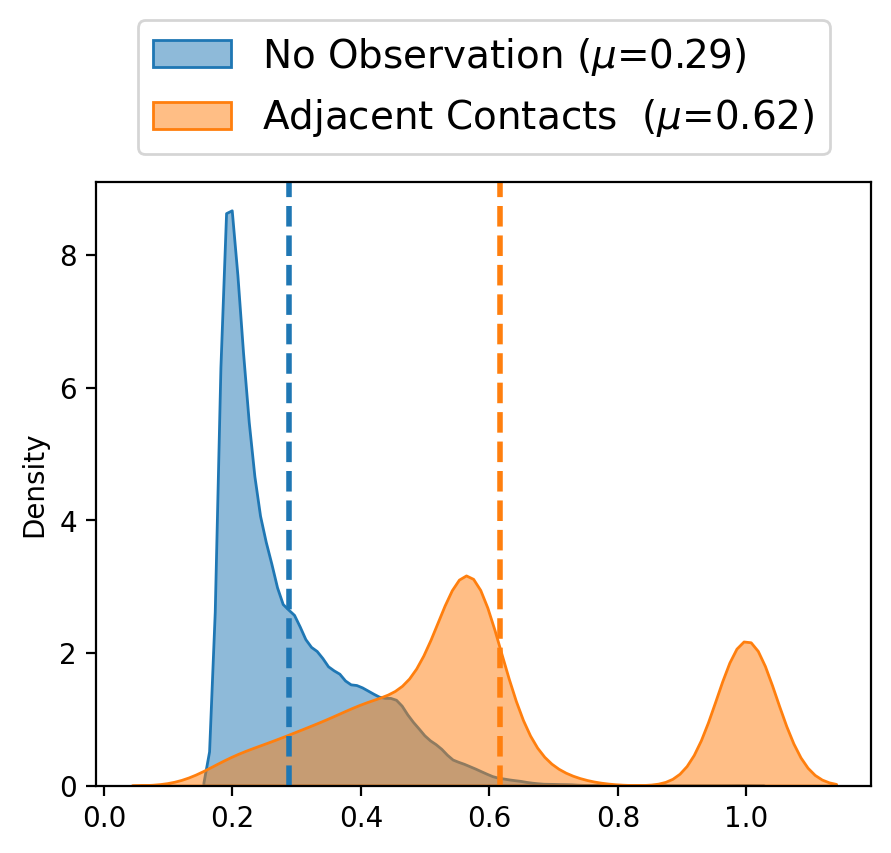

Adjacent Contacts > No Observation (p=0.000)


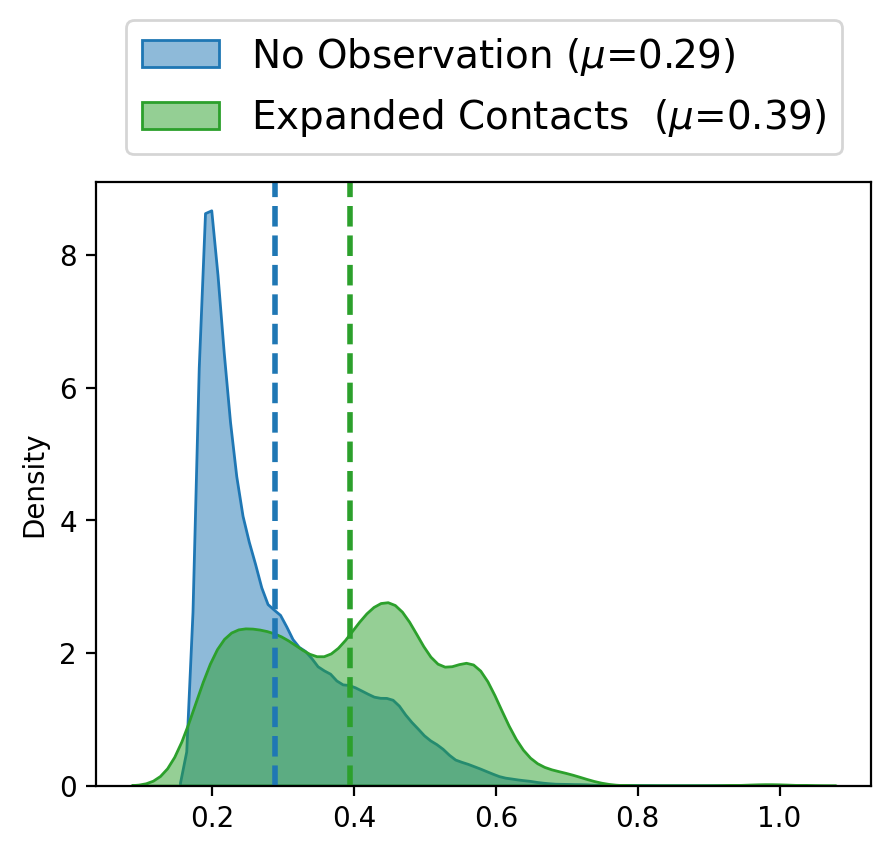

Expanded Contacts > No Observation (p=0.000)


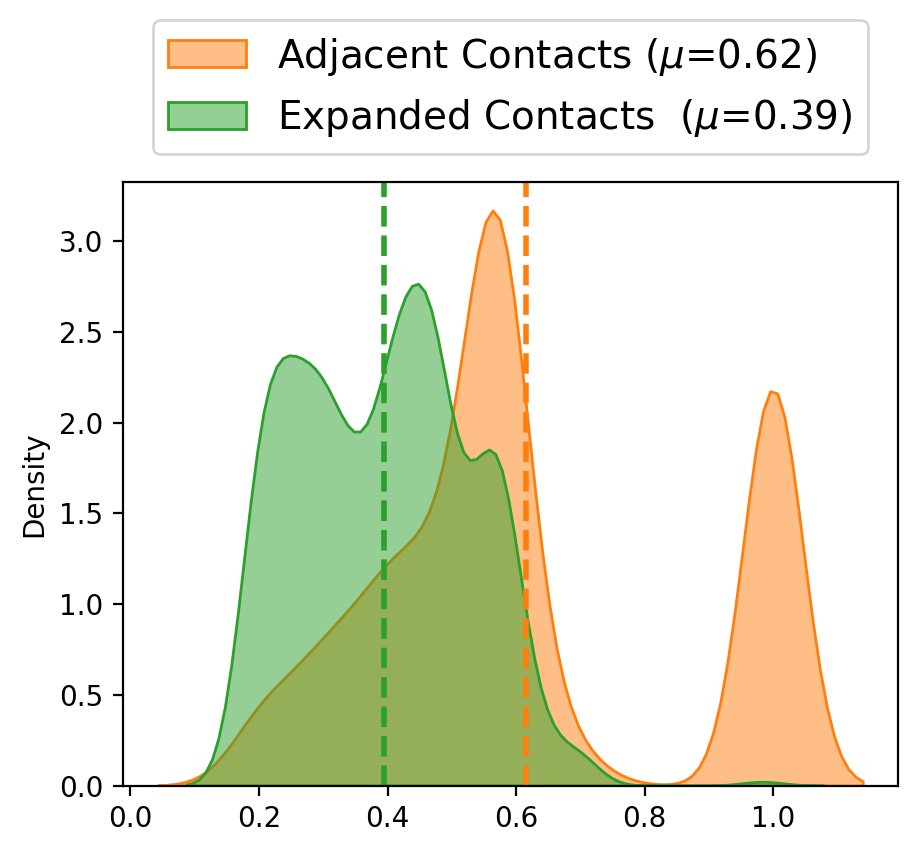

Expanded Contacts > Adjacent Contacts (p=1.000)


<Figure size 1000x800 with 0 Axes>

In [74]:

nObsAll = []
adjAll = []
expAll = []

for runId, A in mats.items():
    noObs =  np.where(A == 0, pXNorm, 0)
    adjOnly = np.where(A == 1, pXNorm, 0)
    expOnly = np.where(A == 2, pXNorm, 0)
    
    # remove zero value entries, they shouldn't be considered
    noObsVec = noObs[noObs > 0]
    adjOnlyVec = adjOnly[adjOnly > 0]
    expOnlyVec = expOnly[expOnly > 0]
    
    nObsAll += list(noObsVec)
    adjAll += list(adjOnlyVec)
    expAll += list(expOnlyVec)
    

conds = {
    'No Observation' : nObsAll,
    'Adjacent Contacts'  : adjAll,
    'Expanded Contacts'  : expAll,
}

colors = {
    'No Observation' : "C0",
    'Adjacent Contacts'  : "C1",
    'Expanded Contacts'  : "C2",
}

tests = list(combinations(conds, 2))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

fig = plt.figure()

for figNum, (i, j) in enumerate(tests):

    t1 = conds[i]
    t2 = conds[j]

    t, p = stats.ttest_ind(t2, t1, 
                           equal_var=False, 
                           alternative='greater')


    nBins = 100

    meant1 = np.mean(t1)
    meant2 = np.mean(t2)

    plt.axvline(x=meant1, ls='--', lw=2, color=colors[i])
    plt.axvline(x=meant2, ls='--', lw=2, color=colors[j])
    
    sns.kdeplot(x=t1, 
                shade=True,
                alpha=0.5,
                gridsize=nBins,
                label=f'{i} ($\mu$={meant1:.2f})',
                color=colors[i])
    
    sns.kdeplot(x=t2, 
                shade=True,
                alpha=0.5,
                gridsize=nBins,
                label=f'{j}  ($\mu$={meant2:.2f})', 
                color=colors[j])
    
    
    plt.legend(loc='upper center',
               ncol=1, fontsize=14,
               bbox_to_anchor=(0.5, 1.3))
    
    plt.show()
    
    print(f"{j} > {i} (p={p:.3f})")

    
#     ax = plt.gca()
#     at = AnchoredText(
#         f"{j} > {i} (p={p:.3f})", prop=dict(size=8), frameon=True, loc='lower right')
#     at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax.add_artist(at)

plt.tight_layout()

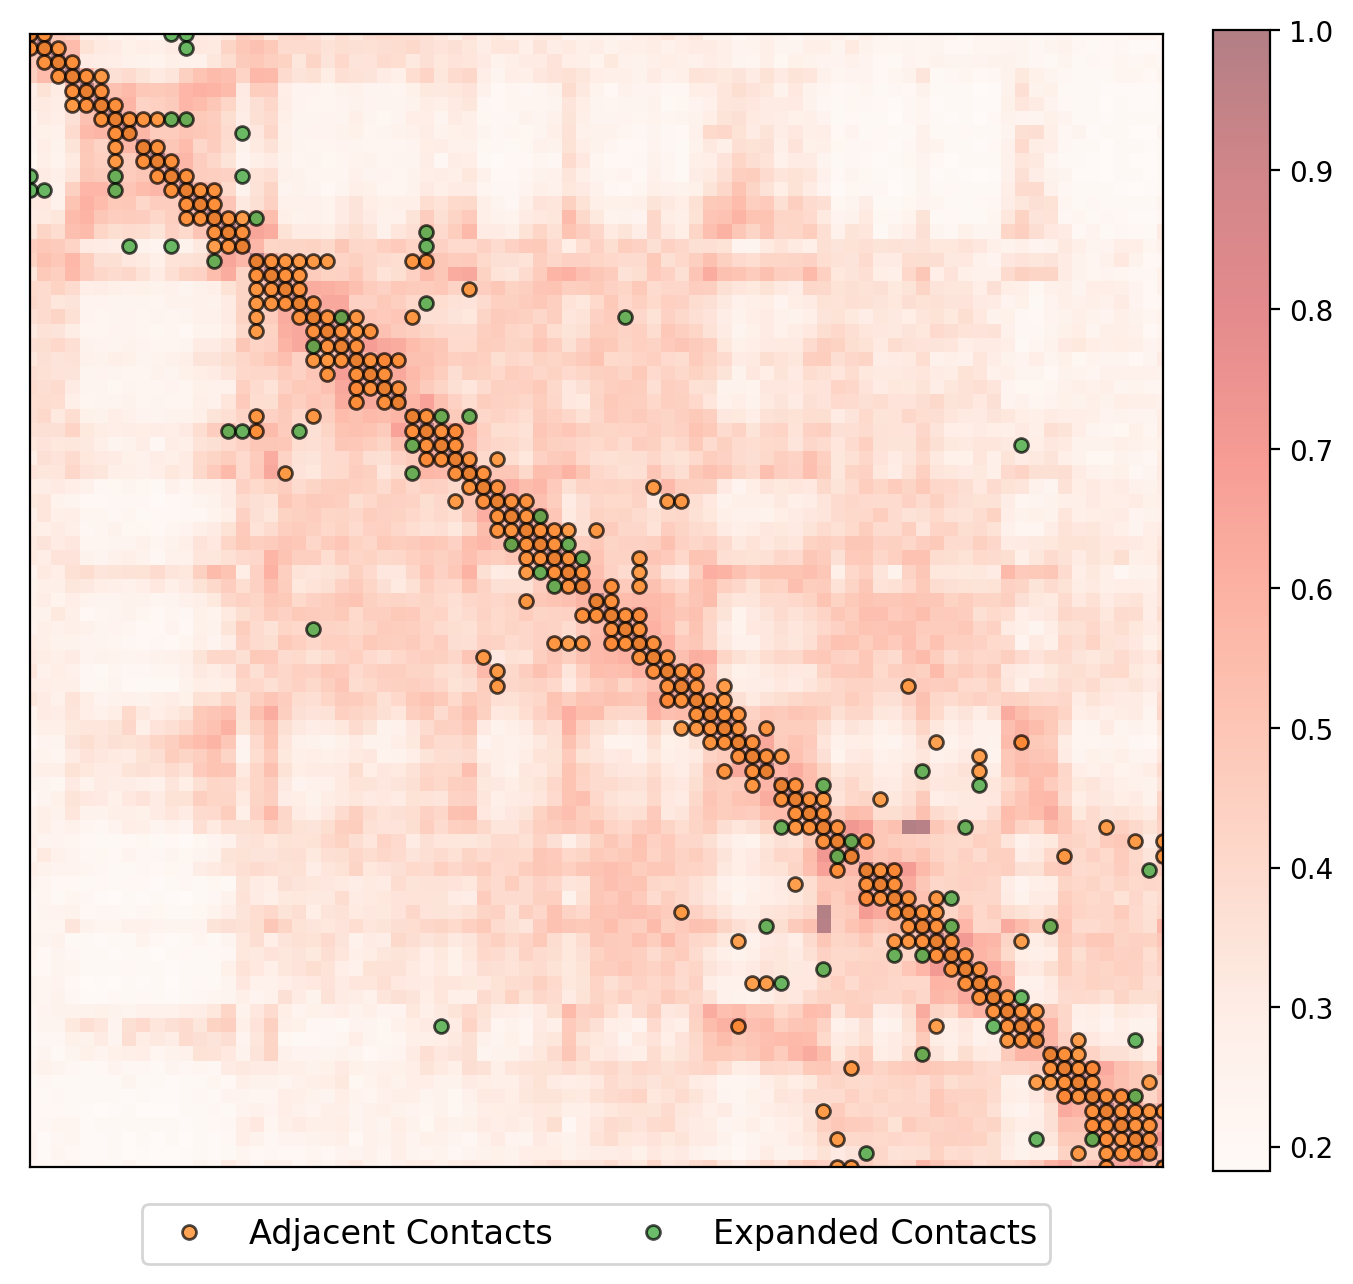

In [90]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 8


for runId, A in mats.items():
    noObs =  np.where(A == 0, pXNorm, 0)
    adjOnly = np.where(A == 1, pXNorm, 0)
    expOnly = np.where(A == 2, pXNorm, 0)
    
#     for pxMap in [adjOnly, expOnly]:
    
    
    plotPx = pcu.dropZeroRows(pXNorm, threshold=28)

    plt.imshow(plotPx, 
               cmap='Reds',
               alpha=0.5, 
               vmin=plotPx.min(), 
               vmax=plotPx.max())
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.spy(adjOnly, 
#             c='C1', 
            marker='.',
            alpha=0.7,
            markerfacecolor='C1',
            markeredgecolor='k',
            markersize=10,
            label='Adjacent Contacts')
    
    plt.spy(expOnly, 
#             c='C2', 
            marker='.',
            alpha=0.7,
            markerfacecolor='C2',
            markeredgecolor='k',
            markersize=10,
            label='Expanded Contacts')

    plt.xlim(20, 100)
    plt.ylim(100, 20)
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.legend(loc='lower center', ncol=5, 
               fontsize=12, 
               bbox_to_anchor=(0.5, -0.1))

    plt.show()
    
    break
    



# plt.title('Frequency of Observation')
# plt.xlabel("Bin (1Mb)")